In [17]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import fsolve

years = [1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965]
rice_production = [-39.69, -7.51, -44.61, 0, -32.53, -43.36, -59.23, -76.33, -85.63, -23.83, -30.49, -29.0]
positive_rice_production = [(val + 100.0) * 3 for val in rice_production]

def system(t, y, Eh, *params):
  S, L, G = y

  a1, a2, b1, b5, c1, c2, c3 = params

  #Sparrows live 3 years on average
  a3 = 1/3

  #Locusts die and lay new eggs every year
  b4 = 1

  #Locusts multiply about 15% faster while gregarious
  b2 = 0.15 * b1

  #To make the locusts swarms turn on quickly
  b3 = 0.01

  c3 = 1



  def f(L):
    return b1 + (b2 * L**2) / (b3**2 + L**2)

  dS = (a1 * S * L) + (a2 * G * S) - (a3 * S) - (Eh * S)
  dL = f(L) * L - (b4 * L) - (b5 * S * L)
  dG = 1 - (c1 * G * S) - (c2 * G * L) - (c3 * G)

  return [dS, dL, dG]

#         a1,    a2,   b1,   b5,    c1,    c2,    c3
params = [0.001, 0.00, 1.50, 0.005, 0.001, 0.005, 0.05]

S0 = 10
L0 = 100
G0 = positive_rice_production[0]




t_span = (0, 30)
t_eval = np.linspace(0, 30, 100)


def run_simulation(Eh=0.0, S0=S0, L0=L0, G0=G0):
  """Simulate and optionally plot the system for given hunting/farming efforts."""
  y0 = [S0, L0, G0]
  sol = solve_ivp(system, t_span, y0, t_eval=t_eval, args=(Eh, *params))
  plt.figure(figsize=(8,5))
  plt.plot(sol.t, sol.y[0], label=f'Sparrows')
  plt.plot(sol.t, sol.y[1], label=f'Locusts')
  plt.plot(sol.t, sol.y[2], label=f'Grain')
  # plt.plot(sol.t, positive_rice_production, label=f'Chicago Rice Data')
  plt.xlabel('Time (years)')
  plt.ylabel('Individuals / Index')
  plt.title(f'Simulation: Eh={Eh}')
  plt.legend()
  plt.grid(True)
  plt.show()

  print("Year |   S (sparrows)   |   L (locusts)   |   G (grain)")
  print("-" * 52)
  for year, S, L, G in zip(years, *sol.y):
    print(f"{year:<5} | {S:>15.3f} | {L:>15.3f} | {G:>15.3f}")




# S0, L0, G0 = findSteadyState(0.001, 0.005)
# ratio = G0 / positive_rice_production[0]
# S0, L0, G0 = S0 * ratio, L0 * ratio, G0 * ratio


In [18]:
"""
A couple nice functions that report steady states and their equilibrium.
"""
def report_steady_state(S: float, L: float, G: float):
    print(f"Sparrow population: {S:.3f}")
    print(f"Locust population: {L:.3f}")
    print(f"Grain: {G:.3f}")

def report_equilibrium(*eigenvalues: float):
    """
    Prints eigenvalues and classifies stability.

    TODO: Due to floating point, an == 0 check is unlikely. We may consider
    having some small value epsilon, and use this to check if things are zero.
    """
    for i, lam in enumerate(eigenvalues, start=1):
        print(f"λ_{i} = {lam}")

    # Use real parts when deciding stability
    eps = 1e-12
    reals = [lam.real for lam in eigenvalues]

    has_pos = any(r > eps for r in reals)
    has_neg = any(r < -eps for r in reals)
    has_zero = any(abs(r) <= eps for r in reals)

    if has_zero:
        print("Classification: equilibrium with a zero eigenvalue (nonhyperbolic)")
    elif has_pos and has_neg:
        print("Classification: unstable saddle equilibrium")
    elif has_pos and not has_neg:
        print("Classification: unstable equilibrium")
    elif has_neg and not has_pos:
        print("Classification: stable equilibrium")
    else:
        print("Classification: unable to classify (unexpected case)")

In [19]:
import numpy as np
from scipy.stats import qmc

def run_lhs_simulations(n_samples=10, Eh=0.0, param_bounds=None):
  #General approach of Latin hypercube sampling and sample inputs not original
  #Customized range, finding initial steady state before solving the equations
  #Also spent a lot of time dealing with weird behavior
    # global params  # reuse the global params variable

    if param_bounds is None:
        # Default bounds for each parameter (a1, a2, b1, b5, c1, c2, c3)
        param_bounds = [
            (0.001, 0.01),   # a1
            (0.0, 0.1),      # a2
            (0.5, 2.5),       # b1
            (0.001, 0.01),    # b5
            (0.0001, 0.01),   # c1
            (0.001, 0.01),    # c2
            (0.01, 0.1)       # c3
        ]

    # Create LHS sampler
    sampler = qmc.LatinHypercube(d=len(param_bounds))
    sample = sampler.random(n=n_samples)

    # Scale samples to parameter bounds
    l_bounds = [low for low, high in param_bounds]
    u_bounds = [high for low, high in param_bounds]
    scaled_samples = qmc.scale(sample, l_bounds, u_bounds)

    results = []


    def f(L: float) -> float:
        return b1 + (b2 * (L**2))/(b3**2 + L**2)

    def dfdx(L: float) -> float:
        return (2 * b2 * (b3**2) * L)/((b3**2 + L**2) ** 2)
    def coexistence_equation_scalar(L: float) -> float:
        """
        It is possible to solve for the values of S and G in terms of L.

        We build an equation whose root corresponds to the L at a steady state,
        so we can calculate S and G from that root.

        Deriving this function:

        dL/dt = 0 gets us to f(L) - b4 - b5 * S = 0, so S(L) = (f(L) - b4) / b5

        dG/dt = 0 gets us to G(L) = 1 / (c1 * S(L) + c2 * L + c3)

        dS/dt = 0 gets us to a1 * S * L + a2 * S * G - a3 * S - Eh * S = 0.
        Since S > 0, we can write this as a1 * L + a2 * G = a3 + Eh.

        > a1 * L + a2 * G = a3 + Eh <  is true at equilibrium.
        So then, we can set F(L) = a1*L + a2 / (c1*S(L) + c2*L + c3) - (a3 + Eh)
        and having this value equal to 0 gives us the L at equilibrium.

        We then use a root solver on F.
        """
        if L <= 0:
            return float("nan")

        S = (f(L) - b4) / b5
        if S < 0:
            return float("nan")

        denom = c1*S + c2*L + c3
        G = 1.0 / denom
        if G < 0:
            return float("nan")

        return a1*L + a2*G - (a3 + Eh)


    for i, param_set in enumerate(scaled_samples):
        print(f"\n--- Simulation {i+1} with params {param_set} ---")
        params = param_set  # update global params
        a1, a2, b1, b5, c1, c2, c3 = params

        #Sparrows live 3 years on average
        a3 = 1/3

        #Locusts die and lay new eggs every year
        b4 = 1

        #Locusts multiply about 15% faster while gregarious
        b2 = 0.15 * b1

        #To make the locusts swarms turn on quickly
        b3 = 0.01

        c3 = 1
        def find_coexistence_equilibrium_fsolve():
            """
            Shove our problems at scipy and win.
            """
            L0 = 1.0
            Eh = 0.0

            L_star = fsolve(coexistence_equation_scalar, L0)[0]

            if L_star <= 0 or not np.isfinite(L_star):
                print("fsolve returned invalid L*")
                return None

            S_star = (f(L_star) - b4) / b5
            denom = c1*S_star + c2*L_star + c3
            G_star = 1.0 / denom

            if S_star < 0 or G_star < 0:
                print("Invalid result for case D, coexistence. ")
                return None

            return S_star, L_star, G_star


        steadyState = find_coexistence_equilibrium_fsolve()
        if steadyState is None:
            print("Steady state not found")
            continue
        S0, L0, G0 = find_coexistence_equilibrium_fsolve()
        run_simulation(Eh=Eh, S0=S0, L0=L0, G0=G0)
        results.append(param_set)

    return results




--- Simulation 1 with params [0.00640379 0.03983524 2.30267965 0.00420445 0.00592513 0.00660328
 0.07133741] ---


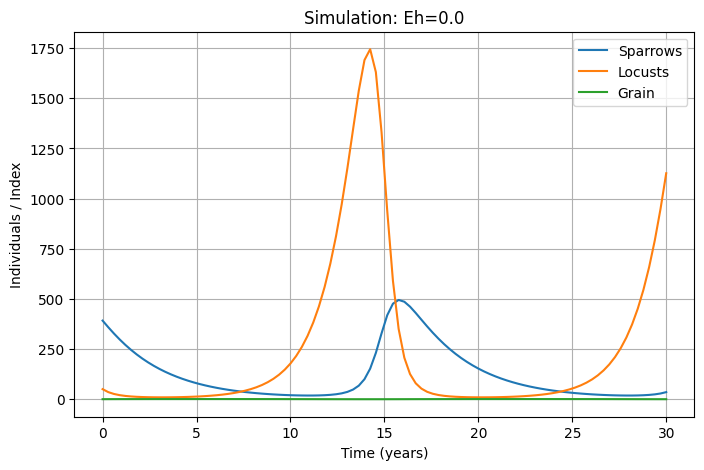

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         391.985 |          50.351 |           0.274
1955  |         358.902 |          35.513 |           0.411
1956  |         327.437 |          26.307 |           0.505
1957  |         298.062 |          20.399 |           0.574
1958  |         270.926 |          16.518 |           0.626
1959  |         246.021 |          13.914 |           0.667
1960  |         223.261 |          12.147 |           0.701
1961  |         202.516 |          10.961 |           0.729
1962  |         183.644 |          10.198 |           0.752
1963  |         166.502 |           9.749 |           0.772
1964  |         150.944 |           9.549 |           0.789
1965  |         136.836 |           9.565 |           0.805

--- Simulation 2 with params [0.00711551 0.06300213 0.66713892 0.00145461 0.00857438 0.00208545
 0.05766727] ---
Invalid result for case D, coexistence. 
Steady state not

/tmp/ipython-input-589297013.py:101: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  L_star = fsolve(coexistence_equation_scalar, L0)[0]


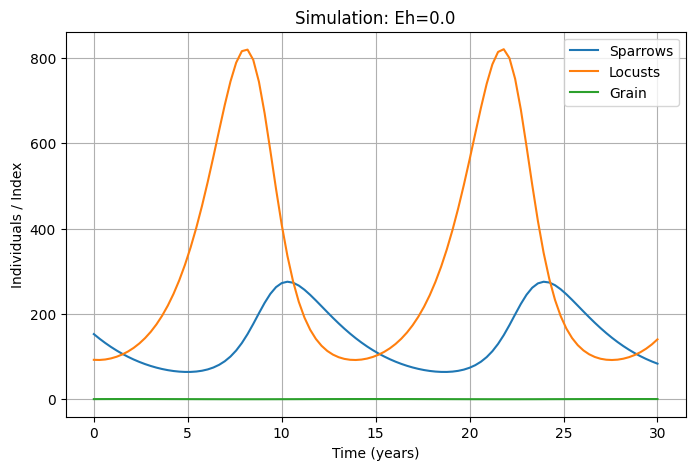

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         152.824 |          92.528 |           0.444
1955  |         142.057 |          92.196 |           0.513
1956  |         132.064 |          93.321 |           0.556
1957  |         122.843 |          95.844 |           0.582
1958  |         114.377 |          99.764 |           0.598
1959  |         106.644 |         105.125 |           0.605
1960  |          99.618 |         112.020 |           0.606
1961  |          93.273 |         120.582 |           0.602
1962  |          87.583 |         130.987 |           0.593
1963  |          82.525 |         143.452 |           0.581
1964  |          78.081 |         158.238 |           0.565
1965  |          74.236 |         175.648 |           0.546

--- Simulation 4 with params [5.70348862e-03 1.68073696e-02 2.04374613e+00 2.54571678e-03
 1.87721059e-03 5.91006417e-03 9.46092391e-02] ---


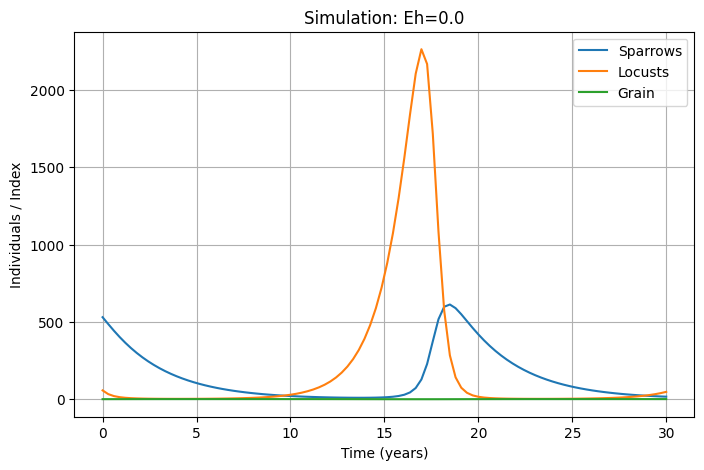

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         530.424 |          57.181 |           0.429
1955  |         485.866 |          32.968 |           0.491
1956  |         442.656 |          20.323 |           0.544
1957  |         402.136 |          13.352 |           0.589
1958  |         364.730 |           9.308 |           0.627
1959  |         330.487 |           6.849 |           0.659
1960  |         299.279 |           5.299 |           0.688
1961  |         270.916 |           4.285 |           0.713
1962  |         245.179 |           3.610 |           0.735
1963  |         221.848 |           3.162 |           0.756
1964  |         200.716 |           2.866 |           0.775
1965  |         181.584 |           2.673 |           0.792

--- Simulation 5 with params [0.00242867 0.03552901 0.60277926 0.00476215 0.00327215 0.00751436
 0.062334  ] ---
Invalid result for case D, coexistence. 
Steady state not

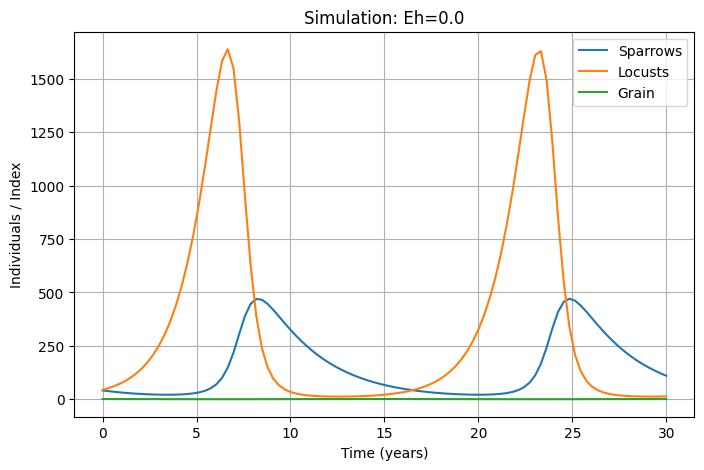

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          41.423 |          44.128 |           0.849
1955  |          37.990 |          51.764 |           0.827
1956  |          34.930 |          61.020 |           0.804
1957  |          32.216 |          72.243 |           0.779
1958  |          29.825 |          85.865 |           0.752
1959  |          27.738 |         102.403 |           0.721
1960  |          25.939 |         122.485 |           0.685
1961  |          24.421 |         146.871 |           0.646
1962  |          23.180 |         176.485 |           0.603
1963  |          22.221 |         212.422 |           0.556
1964  |          21.559 |         255.991 |           0.507
1965  |          21.223 |         308.732 |           0.456

--- Simulation 7 with params [0.00463325 0.07307881 0.82722461 0.00586409 0.00467403 0.00960318
 0.01388919] ---
Invalid result for case D, coexistence. 
Steady state not

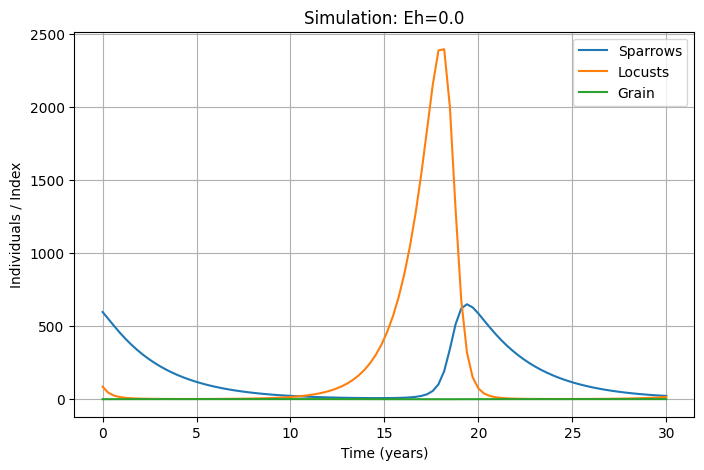

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         597.231 |          85.586 |           0.179
1955  |         550.195 |          44.650 |           0.333
1956  |         502.437 |          25.046 |           0.437
1957  |         456.861 |          15.090 |           0.512
1958  |         414.491 |           9.716 |           0.570
1959  |         375.582 |           6.657 |           0.615
1960  |         340.082 |           4.822 |           0.652
1961  |         307.800 |           3.680 |           0.683
1962  |         278.504 |           2.942 |           0.709
1963  |         251.950 |           2.449 |           0.733
1964  |         227.899 |           2.121 |           0.754
1965  |         206.128 |           1.909 |           0.773

--- Simulation 9 with params [0.00846061 0.04768166 0.70502351 0.00625025 0.00291008 0.00792802
 0.02096867] ---
Invalid result for case D, coexistence. 
Steady state not

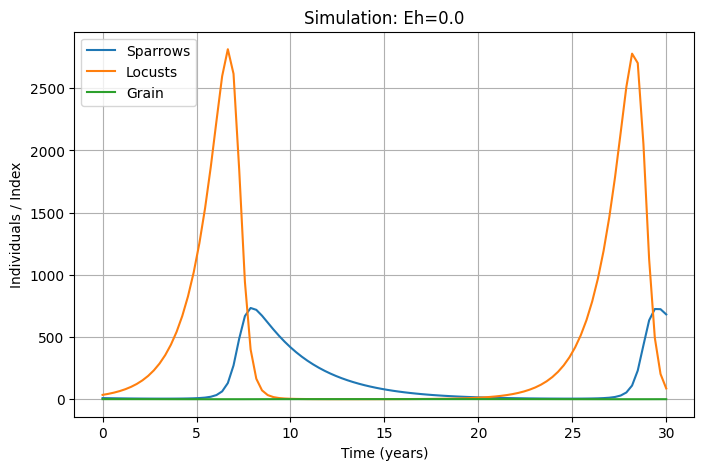

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |           9.187 |          35.083 |           0.805
1955  |           8.403 |          43.125 |           0.813
1956  |           7.707 |          53.070 |           0.810
1957  |           7.092 |          65.370 |           0.795
1958  |           6.553 |          80.597 |           0.772
1959  |           6.087 |          99.446 |           0.741
1960  |           5.690 |         122.779 |           0.703
1961  |           5.361 |         151.668 |           0.658
1962  |           5.100 |         187.448 |           0.606
1963  |           4.911 |         231.743 |           0.550
1964  |           4.801 |         286.569 |           0.491
1965  |           4.780 |         354.401 |           0.431

--- Simulation 13 with params [0.00741716 0.0528205  2.11170852 0.00536375 0.00507633 0.00432531
 0.08313455] ---


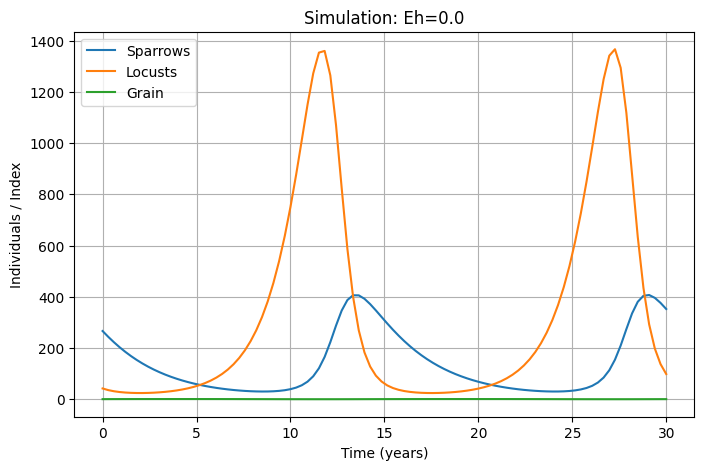

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         266.318 |          42.131 |           0.395
1955  |         243.572 |          35.671 |           0.500
1956  |         222.403 |          31.228 |           0.575
1957  |         202.848 |          28.191 |           0.629
1958  |         184.872 |          26.184 |           0.670
1959  |         168.407 |          24.964 |           0.702
1960  |         153.367 |          24.374 |           0.727
1961  |         139.657 |          24.321 |           0.747
1962  |         127.180 |          24.756 |           0.762
1963  |         115.841 |          25.658 |           0.775
1964  |         105.549 |          27.031 |           0.784
1965  |          96.219 |          28.903 |           0.791

--- Simulation 14 with params [4.30605904e-03 1.58752549e-02 1.72887343e+00 1.00581694e-03
 1.39143648e-03 7.85162210e-03 7.84956630e-02] ---


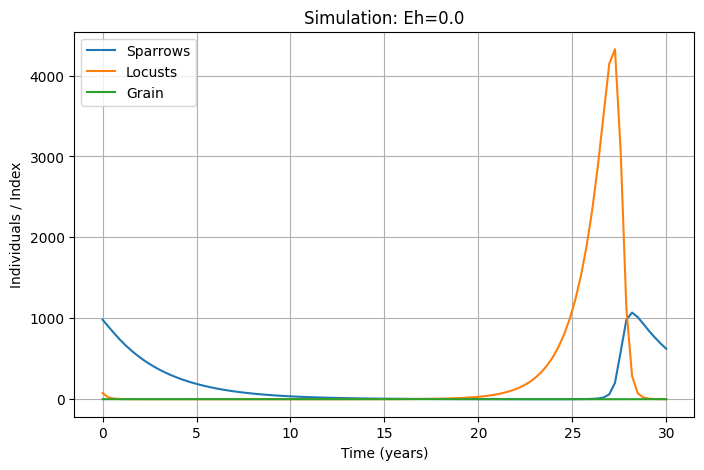

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         982.489 |          76.167 |           0.337
1955  |         899.952 |          22.781 |           0.400
1956  |         816.893 |           7.734 |           0.453
1957  |         739.512 |           2.966 |           0.497
1958  |         668.864 |           1.273 |           0.532
1959  |         604.766 |           0.605 |           0.563
1960  |         546.735 |           0.315 |           0.590
1961  |         494.243 |           0.179 |           0.615
1962  |         446.777 |           0.109 |           0.639
1963  |         403.863 |           0.071 |           0.661
1964  |         365.068 |           0.050 |           0.682
1965  |         329.998 |           0.036 |           0.703

--- Simulation 15 with params [0.00498397 0.08725357 1.54035638 0.00182275 0.0079333  0.00992729
 0.04006565] ---


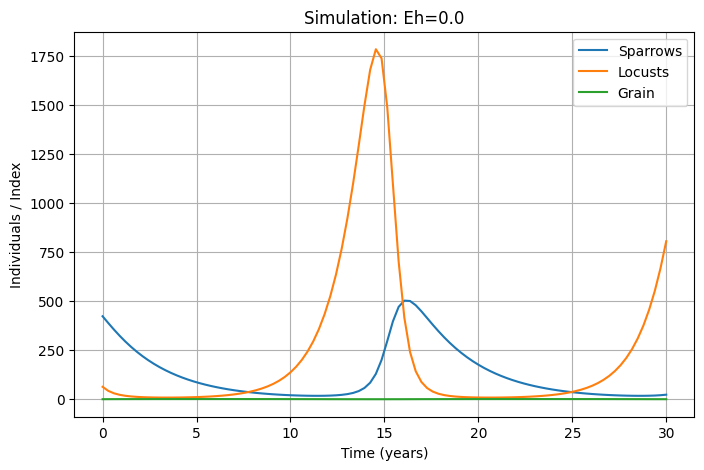

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         423.211 |          63.370 |           0.201
1955  |         388.644 |          42.674 |           0.360
1956  |         355.153 |          30.258 |           0.467
1957  |         323.583 |          22.539 |           0.544
1958  |         294.261 |          17.590 |           0.602
1959  |         267.270 |          14.320 |           0.647
1960  |         242.558 |          12.121 |           0.684
1961  |         220.007 |          10.643 |           0.714
1962  |         199.478 |           9.659 |           0.739
1963  |         180.823 |           9.022 |           0.761
1964  |         163.887 |           8.656 |           0.780
1965  |         148.526 |           8.512 |           0.797

--- Simulation 16 with params [0.00601844 0.00777855 2.25766178 0.00241176 0.00404191 0.00411095
 0.07413835] ---


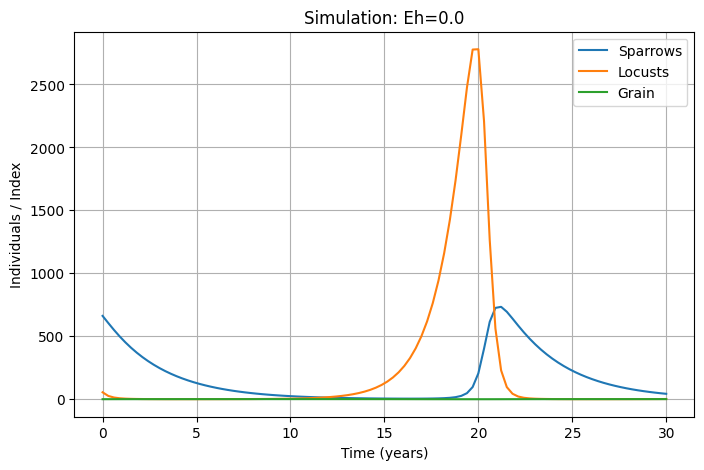

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         661.887 |          55.054 |           0.256
1955  |         605.345 |          26.239 |           0.381
1956  |         550.361 |          13.626 |           0.468
1957  |         499.038 |           7.672 |           0.532
1958  |         451.914 |           4.652 |           0.581
1959  |         408.961 |           3.020 |           0.620
1960  |         369.951 |           2.087 |           0.653
1961  |         334.588 |           1.525 |           0.681
1962  |         302.564 |           1.173 |           0.705
1963  |         273.582 |           0.945 |           0.728
1964  |         247.360 |           0.792 |           0.748
1965  |         223.636 |           0.686 |           0.766

--- Simulation 17 with params [0.00349916 0.02686752 1.45927462 0.00702014 0.00231481 0.00922564
 0.02320962] ---


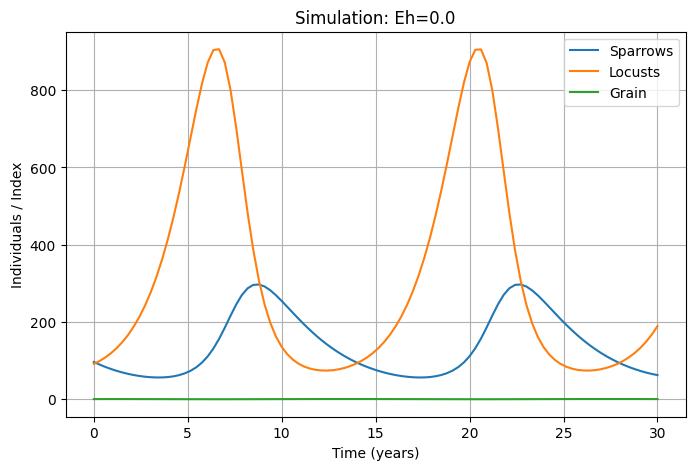

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          96.603 |          91.548 |           0.484
1955  |          89.876 |          99.026 |           0.542
1956  |          83.828 |         108.155 |           0.573
1957  |          78.426 |         119.155 |           0.585
1958  |          73.639 |         132.290 |           0.586
1959  |          69.446 |         147.875 |           0.577
1960  |          65.829 |         166.277 |           0.560
1961  |          62.780 |         187.916 |           0.539
1962  |          60.299 |         213.262 |           0.513
1963  |          58.399 |         242.832 |           0.484
1964  |          57.108 |         277.173 |           0.452
1965  |          56.475 |         316.836 |           0.420

--- Simulation 18 with params [1.28953707e-03 2.21287925e-02 1.84993416e+00 1.95642726e-03
 8.75448115e-03 3.41904518e-03 6.73207707e-02] ---


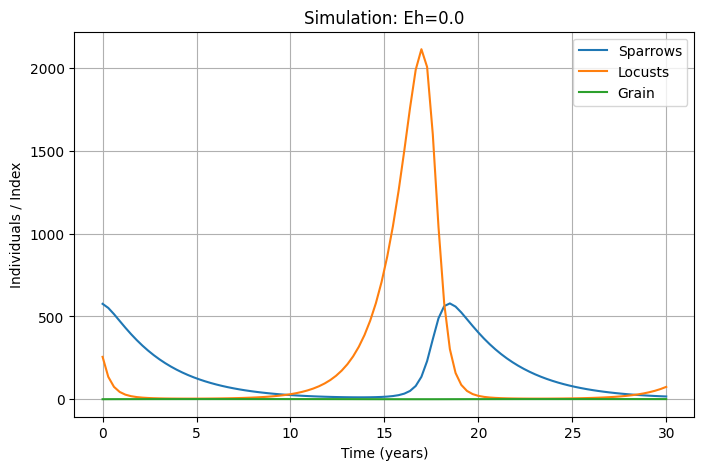

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         576.267 |         256.011 |           0.145
1955  |         551.594 |         135.306 |           0.283
1956  |         514.232 |          74.887 |           0.380
1957  |         473.052 |          44.136 |           0.457
1958  |         432.178 |          27.688 |           0.519
1959  |         393.345 |          18.459 |           0.570
1960  |         357.231 |          13.023 |           0.612
1961  |         324.009 |           9.689 |           0.649
1962  |         293.639 |           7.559 |           0.680
1963  |         265.976 |           6.165 |           0.707
1964  |         240.835 |           5.237 |           0.730
1965  |         218.020 |           4.609 |           0.752

--- Simulation 19 with params [0.00987357 0.04496928 1.07432617 0.00442771 0.00759918 0.00868278
 0.02720733] ---


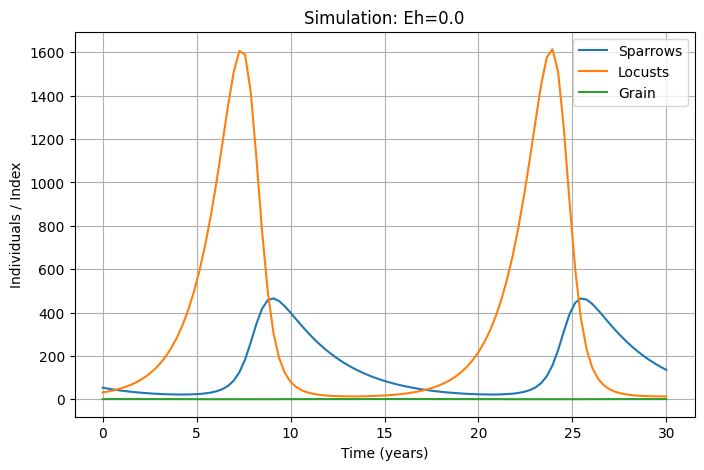

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          53.182 |          31.039 |           0.597
1955  |          48.561 |          35.799 |           0.667
1956  |          44.412 |          41.565 |           0.711
1957  |          40.695 |          48.546 |           0.735
1958  |          37.377 |          57.004 |           0.745
1959  |          34.426 |          67.254 |           0.744
1960  |          31.817 |          79.680 |           0.734
1961  |          29.529 |          94.753 |           0.715
1962  |          27.543 |         113.046 |           0.689
1963  |          25.848 |         135.242 |           0.656
1964  |          24.439 |         162.179 |           0.618
1965  |          23.315 |         194.857 |           0.575

--- Simulation 20 with params [8.94201948e-03 7.49736961e-02 1.12613671e+00 3.33498004e-03
 1.08452857e-03 7.01910619e-03 3.94859517e-02] ---


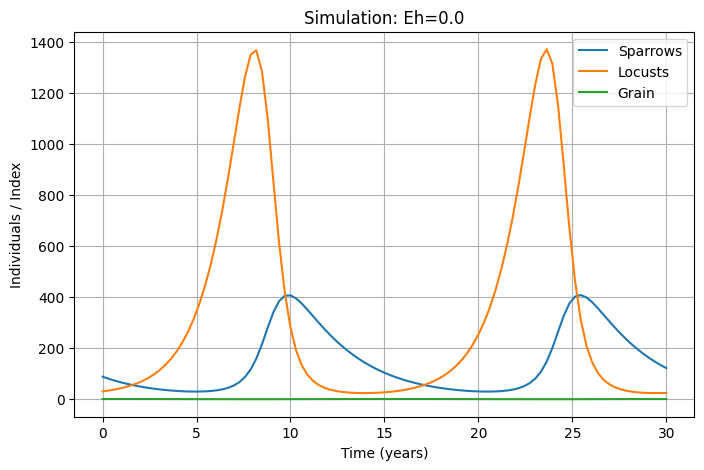

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          88.473 |          30.890 |           0.762
1955  |          80.760 |          33.854 |           0.775
1956  |          73.793 |          37.515 |           0.782
1957  |          67.510 |          41.991 |           0.784
1958  |          61.855 |          47.429 |           0.781
1959  |          56.777 |          54.008 |           0.774
1960  |          52.229 |          61.952 |           0.764
1961  |          48.174 |          71.524 |           0.750
1962  |          44.575 |          83.053 |           0.731
1963  |          41.404 |          96.941 |           0.709
1964  |          38.636 |         113.661 |           0.682
1965  |          36.255 |         133.784 |           0.651

--- Simulation 21 with params [0.00540763 0.09602523 1.25013906 0.00493756 0.00169559 0.00836347
 0.03300699] ---


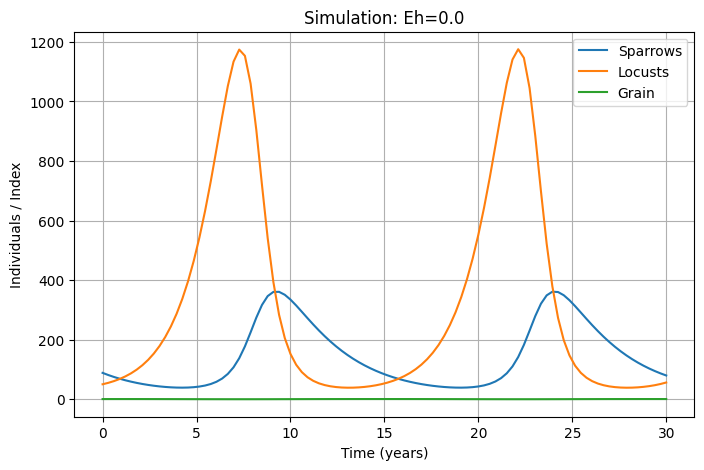

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          88.639 |          50.340 |           0.636
1955  |          81.411 |          55.134 |           0.672
1956  |          74.894 |          61.016 |           0.692
1957  |          69.034 |          68.161 |           0.700
1958  |          63.785 |          76.787 |           0.699
1959  |          59.104 |          87.156 |           0.692
1960  |          54.956 |          99.589 |           0.679
1961  |          51.310 |         114.469 |           0.660
1962  |          48.143 |         132.254 |           0.635
1963  |          45.439 |         153.482 |           0.607
1964  |          43.189 |         178.787 |           0.575
1965  |          41.396 |         208.905 |           0.539

--- Simulation 22 with params [2.70503209e-03 5.73204325e-02 2.46835505e+00 6.57619623e-03
 5.59432826e-03 1.00088387e-03 5.01566922e-02] ---


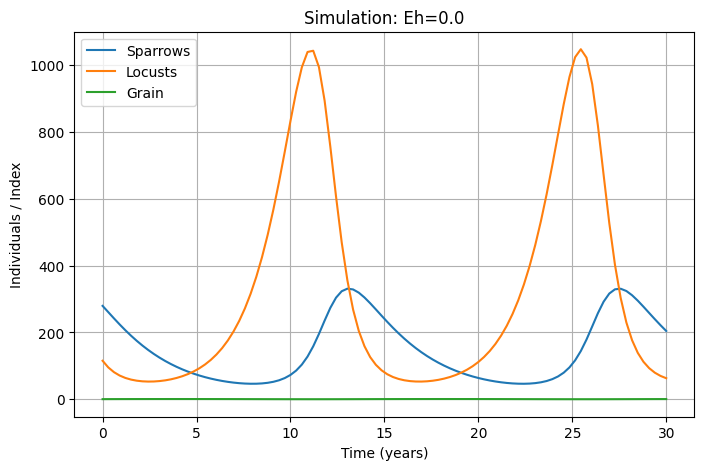

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         279.585 |         115.319 |           0.373
1955  |         260.878 |          95.385 |           0.451
1956  |         242.178 |          81.171 |           0.508
1957  |         223.999 |          71.027 |           0.552
1958  |         206.646 |          63.855 |           0.587
1959  |         190.289 |          58.895 |           0.616
1960  |         175.011 |          55.635 |           0.639
1961  |         160.837 |          53.736 |           0.659
1962  |         147.750 |          52.991 |           0.675
1963  |         135.717 |          53.268 |           0.687
1964  |         124.693 |          54.488 |           0.697
1965  |         114.625 |          56.628 |           0.703

--- Simulation 23 with params [6.99645818e-03 3.13454130e-02 1.66999188e+00 8.40569430e-03
 1.37455595e-04 2.25367659e-03 9.87501590e-02] ---


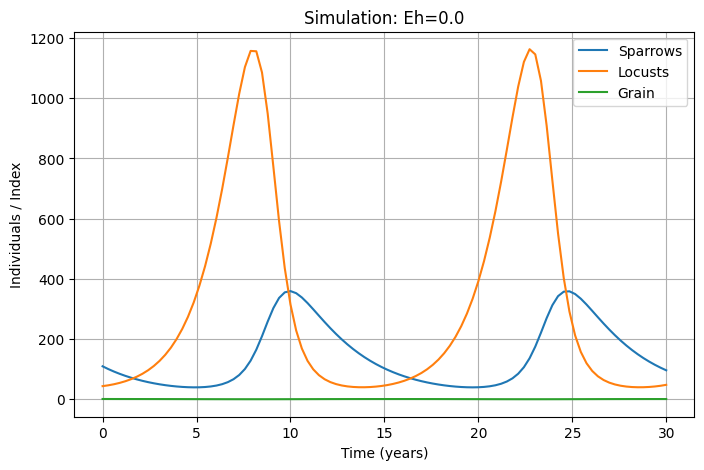

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         109.508 |          43.619 |           0.898
1955  |         100.344 |          46.355 |           0.849
1956  |          92.034 |          49.918 |           0.815
1957  |          84.515 |          54.404 |           0.791
1958  |          77.728 |          59.938 |           0.772
1959  |          71.619 |          66.683 |           0.753
1960  |          66.138 |          74.840 |           0.735
1961  |          61.244 |          84.658 |           0.717
1962  |          56.897 |          96.438 |           0.696
1963  |          53.065 |         110.538 |           0.673
1964  |          49.724 |         127.387 |           0.647
1965  |          46.854 |         147.499 |           0.618

--- Simulation 24 with params [0.0029558  0.09052397 1.97849053 0.00382477 0.00501742 0.00253849
 0.01217134] ---


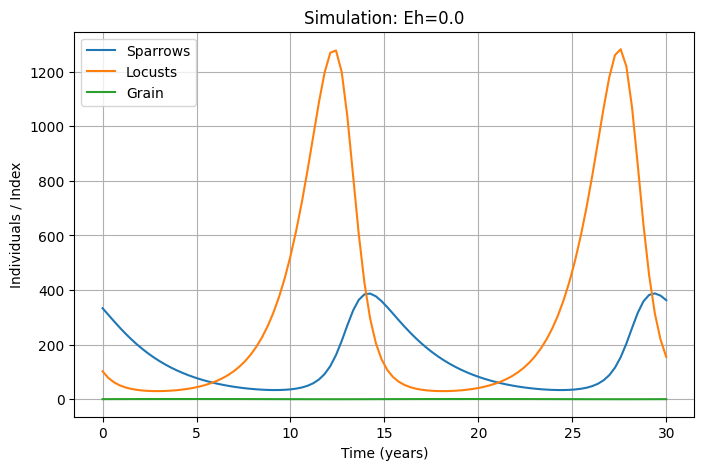

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         333.422 |         102.329 |           0.341
1955  |         309.677 |          78.307 |           0.435
1956  |         285.899 |          62.123 |           0.503
1957  |         262.878 |          51.045 |           0.556
1958  |         241.031 |          43.414 |           0.599
1959  |         220.570 |          38.132 |           0.634
1960  |         201.579 |          34.497 |           0.663
1961  |         184.056 |          32.085 |           0.688
1962  |         167.957 |          30.614 |           0.709
1963  |         153.214 |          29.913 |           0.726
1964  |         139.750 |          29.861 |           0.741
1965  |         127.481 |          30.388 |           0.754

--- Simulation 25 with params [0.00800443 0.07779114 1.95672542 0.00345873 0.00421074 0.00484767
 0.06010477] ---


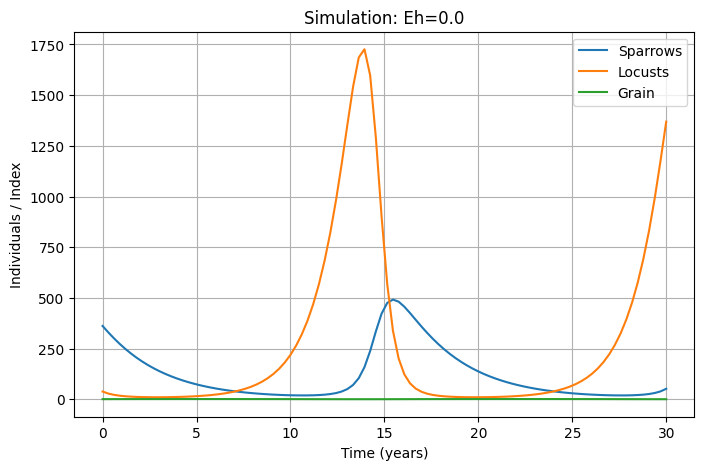

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         361.472 |          38.053 |           0.369
1955  |         329.998 |          28.076 |           0.478
1956  |         300.529 |          21.701 |           0.555
1957  |         273.263 |          17.497 |           0.612
1958  |         248.210 |          14.685 |           0.657
1959  |         225.294 |          12.785 |           0.693
1960  |         204.396 |          11.505 |           0.722
1961  |         185.379 |          10.668 |           0.747
1962  |         168.096 |          10.168 |           0.768
1963  |         152.408 |           9.941 |           0.786
1964  |         138.181 |           9.941 |           0.801
1965  |         125.285 |          10.145 |           0.815

--- Simulation 26 with params [0.00777161 0.00298182 1.58743412 0.00982444 0.00905256 0.00164317
 0.09048412] ---


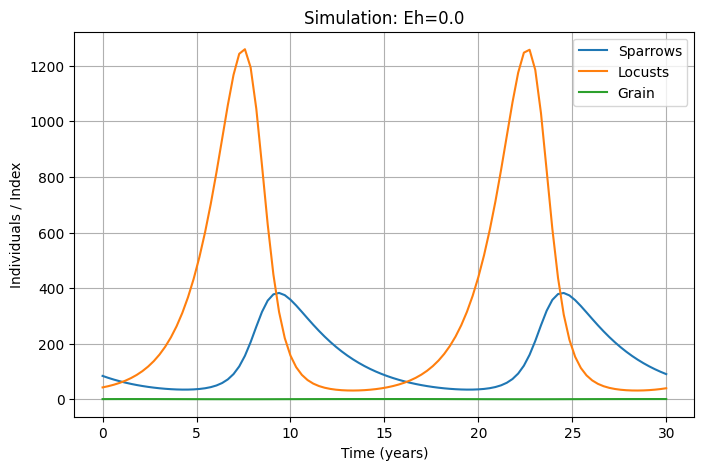

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          84.030 |          42.682 |           0.546
1955  |          76.995 |          47.067 |           0.618
1956  |          70.653 |          52.431 |           0.664
1957  |          64.950 |          58.941 |           0.690
1958  |          59.837 |          66.805 |           0.702
1959  |          55.271 |          76.274 |           0.704
1960  |          51.214 |          87.656 |           0.696
1961  |          47.635 |         101.321 |           0.681
1962  |          44.508 |         117.713 |           0.661
1963  |          41.814 |         137.358 |           0.634
1964  |          39.539 |         160.889 |           0.602
1965  |          37.682 |         189.041 |           0.567

--- Simulation 27 with params [0.00409016 0.06484585 1.36341522 0.00557021 0.00613189 0.00517043
 0.03430465] ---


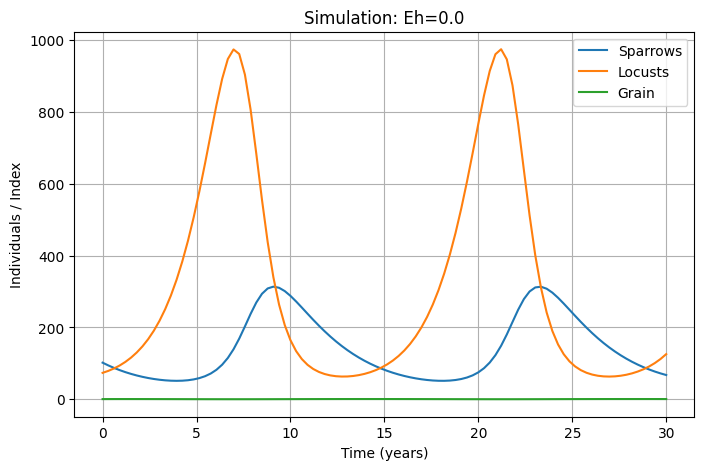

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         101.958 |          73.592 |           0.499
1955  |          94.315 |          79.015 |           0.563
1956  |          87.406 |          85.777 |           0.601
1957  |          81.187 |          94.049 |           0.619
1958  |          75.620 |         104.042 |           0.625
1959  |          70.668 |         116.018 |           0.621
1960  |          66.303 |         130.288 |           0.610
1961  |          62.502 |         147.221 |           0.593
1962  |          59.249 |         167.246 |           0.570
1963  |          56.538 |         190.855 |           0.544
1964  |          54.371 |         218.603 |           0.514
1965  |          52.765 |         251.104 |           0.481

--- Simulation 28 with params [0.00957001 0.02584471 0.99131911 0.00819179 0.0096436  0.00332379
 0.02904621] ---


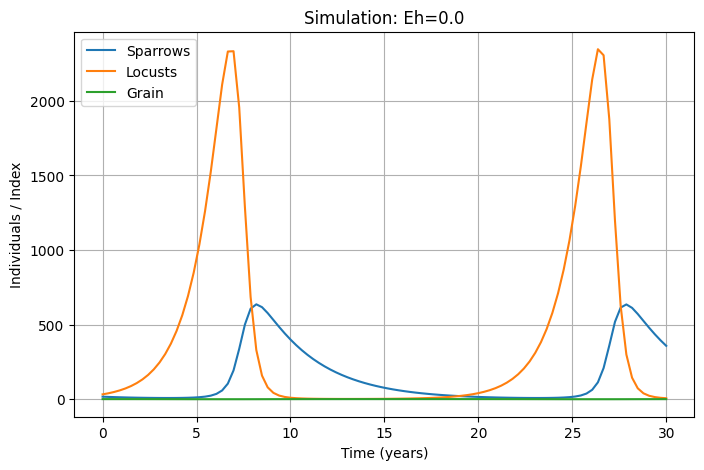

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          17.092 |          32.711 |           0.785
1955  |          15.620 |          39.752 |           0.801
1956  |          14.309 |          48.410 |           0.804
1957  |          13.146 |          59.061 |           0.796
1958  |          12.120 |          72.180 |           0.778
1959  |          11.225 |          88.342 |           0.753
1960  |          10.452 |         108.256 |           0.721
1961  |           9.798 |         132.801 |           0.682
1962  |           9.261 |         163.064 |           0.636
1963  |           8.844 |         200.366 |           0.585
1964  |           8.552 |         246.332 |           0.530
1965  |           8.398 |         302.946 |           0.472

--- Simulation 29 with params [1.66130348e-03 4.99690700e-03 2.20320726e+00 8.92851859e-03
 8.05748601e-03 5.66864929e-03 8.15074428e-02] ---


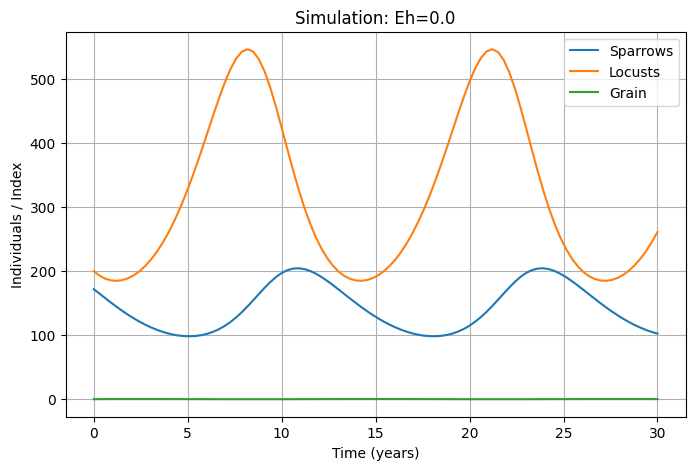

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         171.774 |         199.790 |           0.284
1955  |         164.779 |         192.866 |           0.371
1956  |         157.791 |         188.167 |           0.419
1957  |         150.932 |         185.521 |           0.448
1958  |         144.298 |         184.793 |           0.464
1959  |         137.964 |         185.887 |           0.473
1960  |         131.986 |         188.741 |           0.478
1961  |         126.411 |         193.325 |           0.479
1962  |         121.270 |         199.635 |           0.477
1963  |         116.592 |         207.690 |           0.472
1964  |         112.399 |         217.528 |           0.466
1965  |         108.710 |         229.196 |           0.457

--- Simulation 30 with params [0.00850239 0.04158169 1.4326263  0.00731279 0.00730992 0.00398929
 0.04391565] ---


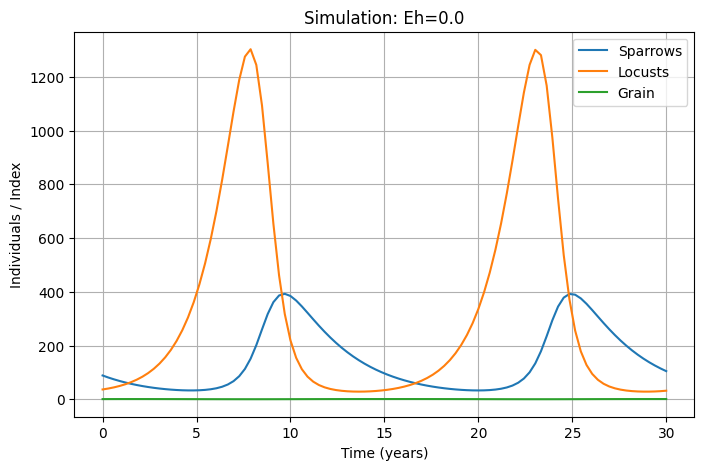

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          88.546 |          36.477 |           0.558
1955  |          80.970 |          39.967 |           0.631
1956  |          74.129 |          44.271 |           0.678
1957  |          67.964 |          49.524 |           0.706
1958  |          62.422 |          55.894 |           0.721
1959  |          57.453 |          63.588 |           0.726
1960  |          53.016 |          72.856 |           0.723
1961  |          49.072 |          84.007 |           0.712
1962  |          45.591 |          97.413 |           0.695
1963  |          42.546 |         113.514 |           0.673
1964  |          39.918 |         132.847 |           0.645
1965  |          37.693 |         156.046 |           0.612

--- Simulation 1 with params [0.00405196 0.07340686 0.84291198 0.00514441 0.00361451 0.00651781
 0.02172985] ---
Invalid result for case D, coexistence. 
Steady state not

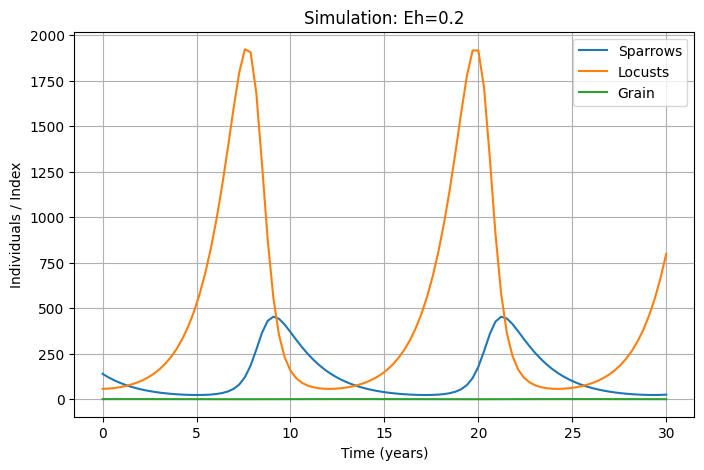

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         139.596 |          57.035 |           0.420
1955  |         120.853 |          58.346 |           0.520
1956  |         104.694 |          61.285 |           0.586
1957  |          90.799 |          65.852 |           0.627
1958  |          78.877 |          72.154 |           0.653
1959  |          68.672 |          80.392 |           0.665
1960  |          59.956 |          90.863 |           0.667
1961  |          52.533 |         103.959 |           0.660
1962  |          46.233 |         120.179 |           0.645
1963  |          40.912 |         140.159 |           0.622
1964  |          36.447 |         164.676 |           0.593
1965  |          32.738 |         194.679 |           0.559

--- Simulation 4 with params [0.00966755 0.07207121 1.53708629 0.00935586 0.00854703 0.00677751
 0.06656137] ---


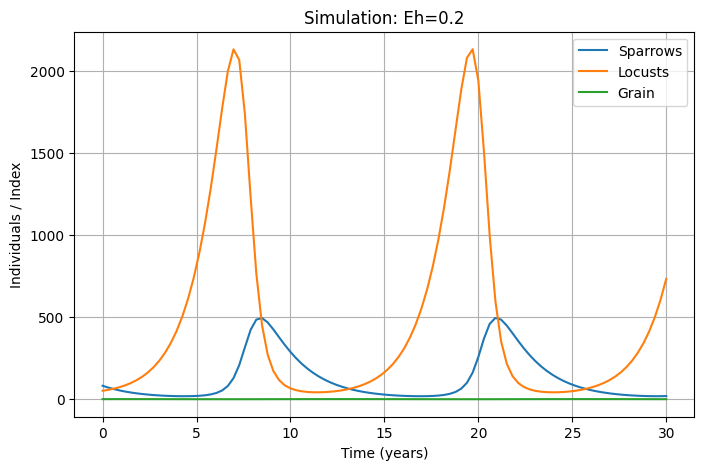

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          82.050 |          51.532 |           0.488
1955  |          70.962 |          57.180 |           0.573
1956  |          61.492 |          64.440 |           0.627
1957  |          53.419 |          73.593 |           0.656
1958  |          46.549 |          85.001 |           0.668
1959  |          40.720 |          99.123 |           0.667
1960  |          35.791 |         116.536 |           0.654
1961  |          31.643 |         137.953 |           0.632
1962  |          28.178 |         164.246 |           0.602
1963  |          25.316 |         196.487 |           0.564
1964  |          22.992 |         235.984 |           0.521
1965  |          21.160 |         284.312 |           0.474

--- Simulation 5 with params [3.34150189e-03 1.12903334e-02 2.36152923e+00 2.08821697e-03
 5.17606432e-03 1.34721637e-03 6.15186481e-02] ---


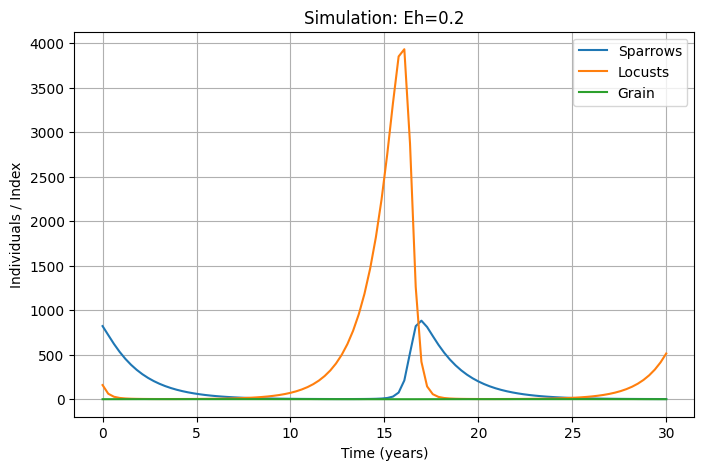

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         821.638 |         158.991 |           0.183
1955  |         720.835 |          61.441 |           0.314
1956  |         621.086 |          27.712 |           0.410
1957  |         531.634 |          14.434 |           0.485
1958  |         453.823 |           8.534 |           0.546
1959  |         386.908 |           5.633 |           0.597
1960  |         329.645 |           4.080 |           0.641
1961  |         280.757 |           3.209 |           0.679
1962  |         239.071 |           2.700 |           0.713
1963  |         203.545 |           2.405 |           0.744
1964  |         173.292 |           2.257 |           0.771
1965  |         147.536 |           2.210 |           0.796

--- Simulation 6 with params [0.00148898 0.06346849 0.99041942 0.00641803 0.00398987 0.0027952
 0.07742064] ---


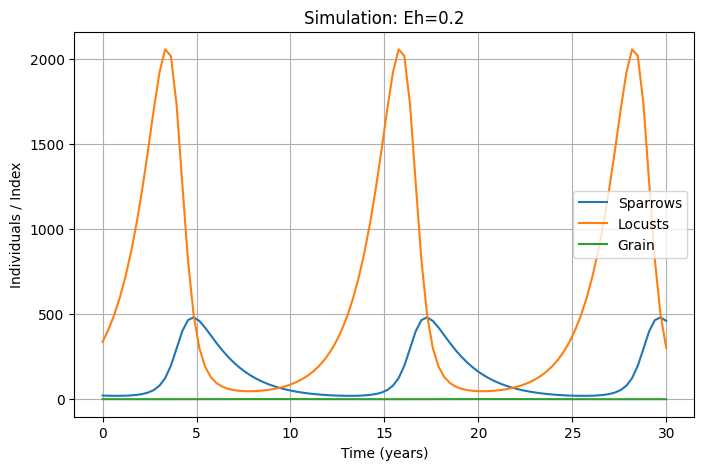

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          21.655 |         337.177 |           0.493
1955  |          20.615 |         406.810 |           0.406
1956  |          20.087 |         491.409 |           0.342
1957  |          20.134 |         593.823 |           0.290
1958  |          20.881 |         717.166 |           0.246
1959  |          22.561 |         864.569 |           0.208
1960  |          25.592 |        1038.629 |           0.176
1961  |          30.731 |        1240.189 |           0.149
1962  |          39.376 |        1465.828 |           0.127
1963  |          54.143 |        1702.814 |           0.110
1964  |          79.840 |        1919.919 |           0.097
1965  |         124.439 |        2054.911 |           0.089

--- Simulation 7 with params [0.00929926 0.02817645 1.06131687 0.0086995  0.00425823 0.00996812
 0.03358251] ---


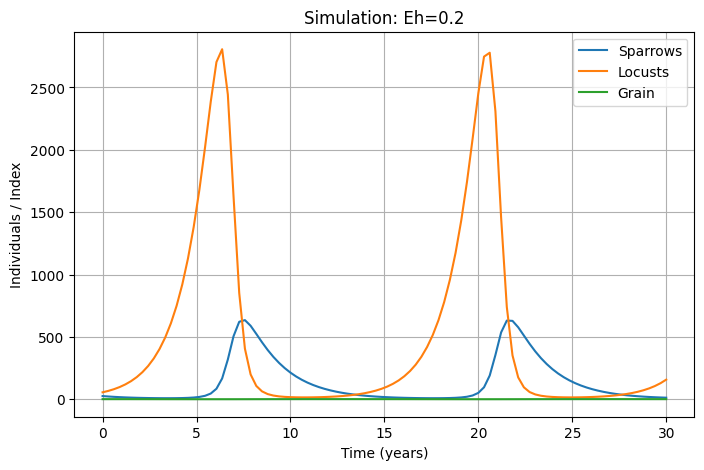

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          25.348 |          55.529 |           0.602
1955  |          21.967 |          66.742 |           0.652
1956  |          19.109 |          80.597 |           0.675
1957  |          16.701 |          97.717 |           0.677
1958  |          14.681 |         118.873 |           0.664
1959  |          12.998 |         145.012 |           0.637
1960  |          11.610 |         177.311 |           0.599
1961  |          10.484 |         217.220 |           0.553
1962  |           9.595 |         266.510 |           0.502
1963  |           8.929 |         327.375 |           0.448
1964  |           8.481 |         402.479 |           0.392
1965  |           8.263 |         495.064 |           0.337

--- Simulation 8 with params [3.69245259e-03 7.18534728e-03 1.21036281e+00 5.67321393e-03
 1.03141477e-03 3.30192961e-03 1.03815288e-02] ---


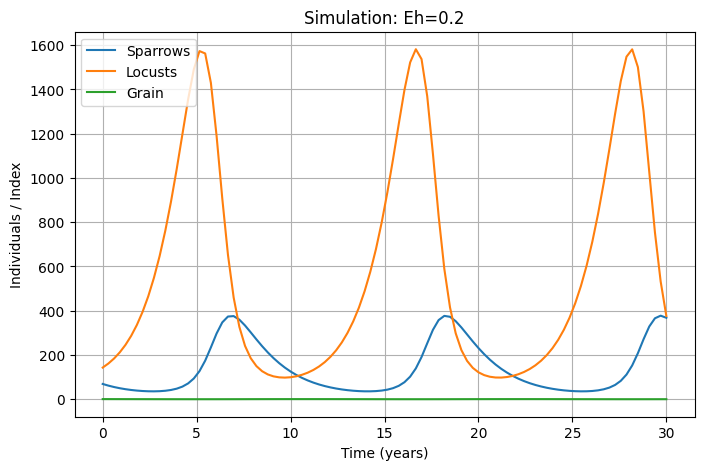

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          69.082 |         143.178 |           0.648
1955  |          61.544 |         161.578 |           0.604
1956  |          55.170 |         184.270 |           0.567
1957  |          49.835 |         212.018 |           0.531
1958  |          45.435 |         245.749 |           0.494
1959  |          41.894 |         286.561 |           0.456
1960  |          39.157 |         335.743 |           0.416
1961  |          37.202 |         394.767 |           0.376
1962  |          36.045 |         465.264 |           0.336
1963  |          35.746 |         548.962 |           0.298
1964  |          36.442 |         647.537 |           0.261
1965  |          38.371 |         762.324 |           0.228

--- Simulation 9 with params [6.52848057e-03 9.60967467e-02 1.80358892e+00 6.28856840e-03
 1.46451010e-03 3.97384837e-03 8.79018860e-02] ---


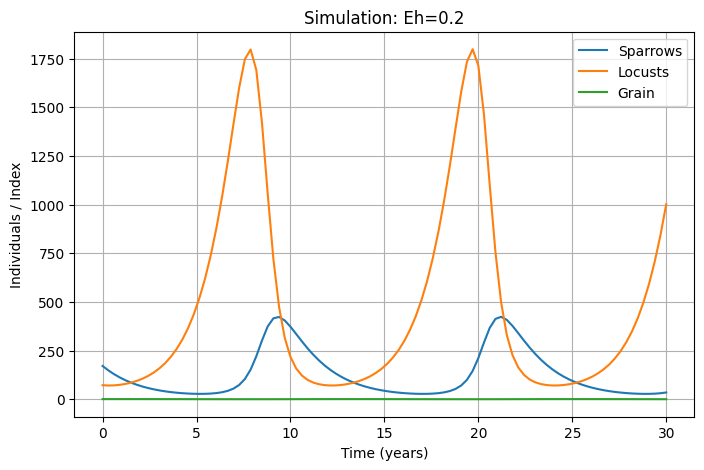

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         170.806 |          72.115 |           0.651
1955  |         148.483 |          70.556 |           0.654
1956  |         129.061 |          71.248 |           0.660
1957  |         112.236 |          73.959 |           0.666
1958  |          97.715 |          78.608 |           0.669
1959  |          85.218 |          85.270 |           0.668
1960  |          74.494 |          94.136 |           0.663
1961  |          65.319 |         105.501 |           0.653
1962  |          57.496 |         119.768 |           0.638
1963  |          50.855 |         137.456 |           0.618
1964  |          45.250 |         159.220 |           0.593
1965  |          40.559 |         185.877 |           0.563

--- Simulation 10 with params [0.00723628 0.04066031 2.01225979 0.004105   0.0079714  0.0024017
 0.05809939] ---


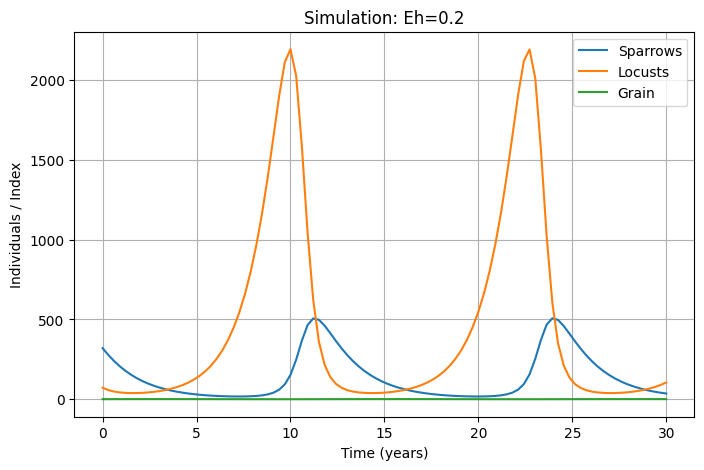

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         320.122 |          72.194 |           0.268
1955  |         277.690 |          57.208 |           0.405
1956  |         240.023 |          48.179 |           0.498
1957  |         207.024 |          42.792 |           0.567
1958  |         178.338 |          39.832 |           0.618
1959  |         153.532 |          38.611 |           0.658
1960  |         132.155 |          38.747 |           0.688
1961  |         113.778 |          40.073 |           0.711
1962  |          98.015 |          42.546 |           0.728
1963  |          84.515 |          46.183 |           0.739
1964  |          72.965 |          51.070 |           0.745
1965  |          63.096 |          57.389 |           0.745

--- Simulation 11 with params [0.00614243 0.00567458 0.69346902 0.00152604 0.0012873  0.0035568
 0.05059989] ---
Invalid result for case D, coexistence. 
Steady state not

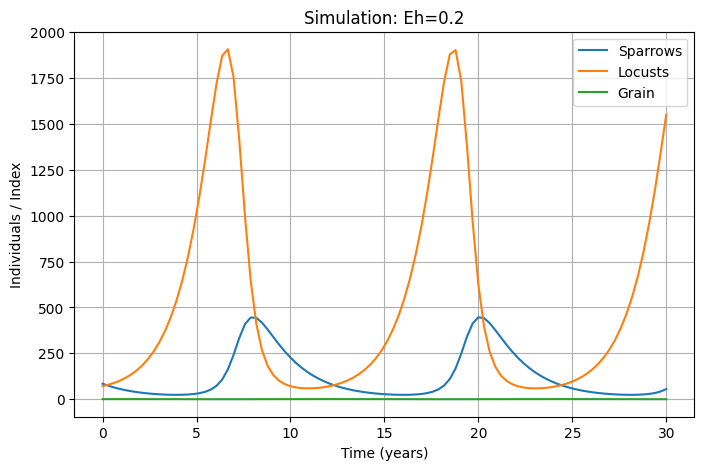

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          84.732 |          71.476 |           0.519
1955  |          73.745 |          78.982 |           0.579
1956  |          64.350 |          88.631 |           0.613
1957  |          56.337 |         100.778 |           0.627
1958  |          49.525 |         115.881 |           0.627
1959  |          43.760 |         134.520 |           0.615
1960  |          38.908 |         157.415 |           0.593
1961  |          34.862 |         185.453 |           0.564
1962  |          31.532 |         219.704 |           0.529
1963  |          28.849 |         261.466 |           0.488
1964  |          26.767 |         312.294 |           0.444
1965  |          25.260 |         374.016 |           0.398

--- Simulation 13 with params [3.71759783e-03 4.77244317e-02 1.88368408e+00 1.12618767e-03
 1.60451960e-04 5.30843857e-03 9.47226919e-02] ---


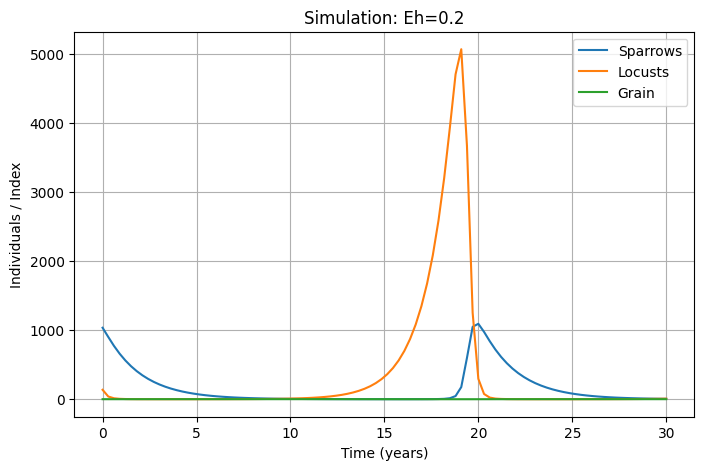

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |        1035.562 |         136.676 |           0.529
1955  |         901.755 |          39.183 |           0.479
1956  |         772.761 |          13.748 |           0.495
1957  |         659.251 |           5.801 |           0.526
1958  |         561.569 |           2.872 |           0.561
1959  |         478.079 |           1.631 |           0.596
1960  |         406.895 |           1.041 |           0.630
1961  |         346.264 |           0.734 |           0.663
1962  |         294.645 |           0.563 |           0.694
1963  |         250.715 |           0.466 |           0.723
1964  |         213.326 |           0.408 |           0.751
1965  |         181.508 |           0.377 |           0.776

--- Simulation 14 with params [0.00507104 0.02268077 0.96338612 0.00383073 0.00185161 0.00284886
 0.02483341] ---


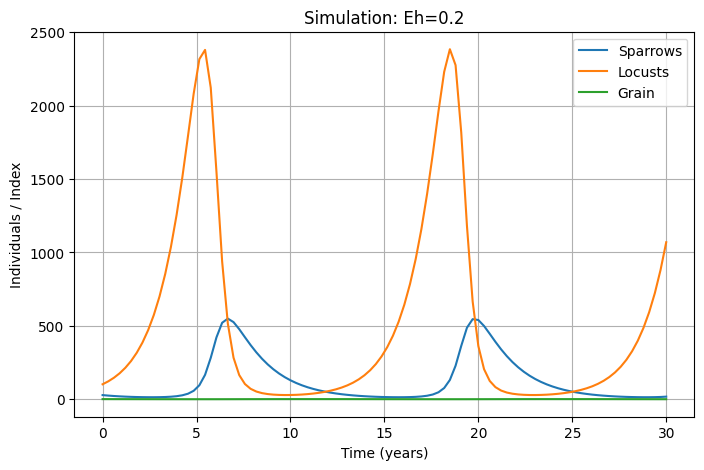

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          28.165 |         101.840 |           0.745
1955  |          24.786 |         121.884 |           0.701
1956  |          21.959 |         146.557 |           0.656
1957  |          19.618 |         176.915 |           0.609
1958  |          17.706 |         214.250 |           0.559
1959  |          16.182 |         260.138 |           0.507
1960  |          15.020 |         316.498 |           0.454
1961  |          14.208 |         385.645 |           0.400
1962  |          13.756 |         470.350 |           0.347
1963  |          13.702 |         573.884 |           0.298
1964  |          14.130 |         700.019 |           0.253
1965  |          15.199 |         852.933 |           0.213

--- Simulation 15 with params [0.00107145 0.06315754 0.52219645 0.00220164 0.00562212 0.00574928
 0.02815954] ---
Invalid result for case D, coexistence. 
Steady state no

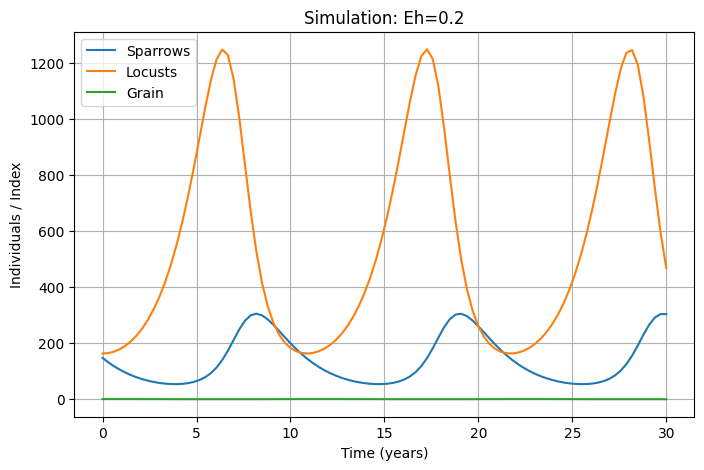

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         147.537 |         163.147 |           0.533
1955  |         131.895 |         164.495 |           0.523
1956  |         118.027 |         169.603 |           0.517
1957  |         105.840 |         178.354 |           0.512
1958  |          95.217 |         190.822 |           0.504
1959  |          86.034 |         207.245 |           0.492
1960  |          78.176 |         228.003 |           0.477
1961  |          71.535 |         253.607 |           0.457
1962  |          66.022 |         284.693 |           0.434
1963  |          61.567 |         322.009 |           0.409
1964  |          58.127 |         366.400 |           0.380
1965  |          55.688 |         418.773 |           0.350

--- Simulation 17 with params [7.88829874e-03 1.71142257e-02 1.34589732e+00 7.57316240e-03
 9.45517840e-03 1.17012672e-03 9.10121661e-02] ---


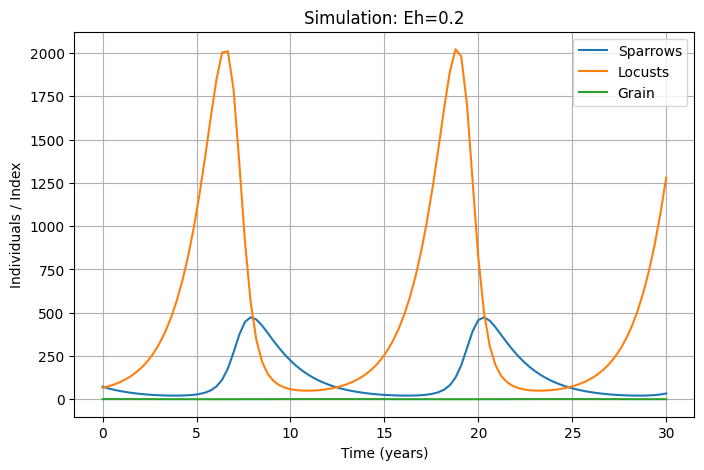

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          72.332 |          66.379 |           0.568
1955  |          62.864 |          74.653 |           0.616
1956  |          54.789 |          85.079 |           0.641
1957  |          47.921 |          98.062 |           0.648
1958  |          42.098 |         114.118 |           0.642
1959  |          37.183 |         133.884 |           0.627
1960  |          33.062 |         158.150 |           0.601
1961  |          29.637 |         187.885 |           0.568
1962  |          26.834 |         224.264 |           0.529
1963  |          24.595 |         268.706 |           0.486
1964  |          22.881 |         322.923 |           0.440
1965  |          21.676 |         388.938 |           0.391

--- Simulation 18 with params [0.00568553 0.08439141 2.22025784 0.00670299 0.00832714 0.00420006
 0.08846462] ---


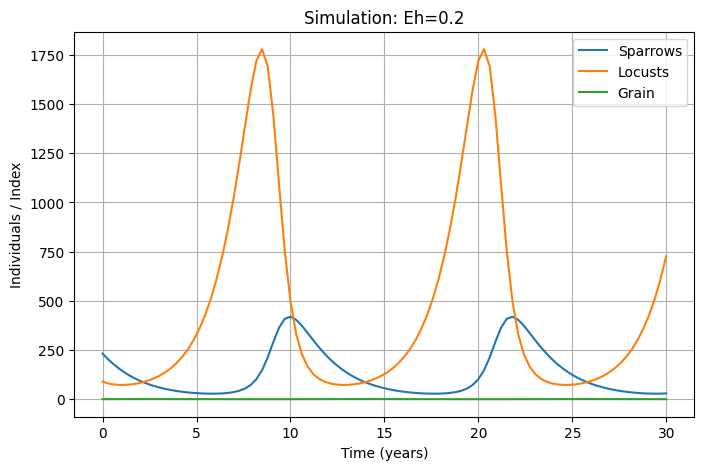

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         231.732 |          89.314 |           0.303
1955  |         202.253 |          80.117 |           0.424
1956  |         176.145 |          74.962 |           0.504
1957  |         153.241 |          72.785 |           0.559
1958  |         133.277 |          73.003 |           0.598
1959  |         115.959 |          75.318 |           0.624
1960  |         100.992 |          79.624 |           0.640
1961  |          88.099 |          85.971 |           0.649
1962  |          77.025 |          94.526 |           0.650
1963  |          67.543 |         105.558 |           0.644
1964  |          59.451 |         119.452 |           0.633
1965  |          52.576 |         136.711 |           0.615

--- Simulation 19 with params [0.00802146 0.08238109 2.14617392 0.00725497 0.00729973 0.00903863
 0.04080451] ---


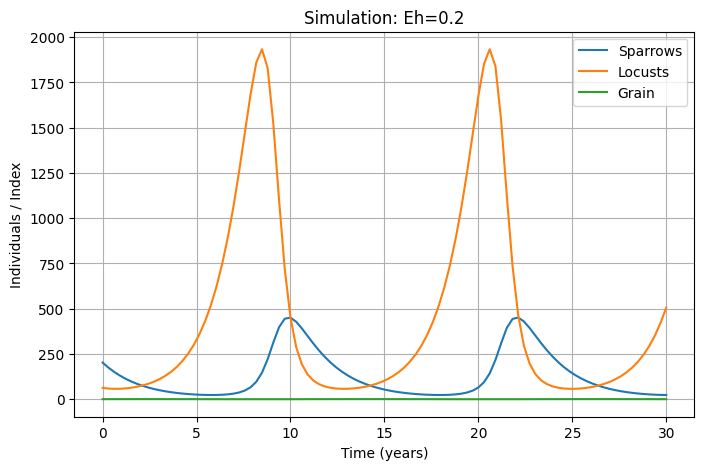

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         202.358 |          63.119 |           0.328
1955  |         175.365 |          59.086 |           0.453
1956  |         151.844 |          57.470 |           0.537
1957  |         131.454 |          57.784 |           0.594
1958  |         113.842 |          59.794 |           0.633
1959  |          98.674 |          63.429 |           0.659
1960  |          85.643 |          68.733 |           0.675
1961  |          74.472 |          75.856 |           0.681
1962  |          64.919 |          85.041 |           0.681
1963  |          56.768 |          96.625 |           0.673
1964  |          49.836 |         111.046 |           0.659
1965  |          43.964 |         128.855 |           0.638

--- Simulation 20 with params [2.69813066e-03 2.02155103e-03 2.49526819e+00 2.57916458e-03
 4.47935788e-03 9.59386852e-03 8.01871911e-02] ---


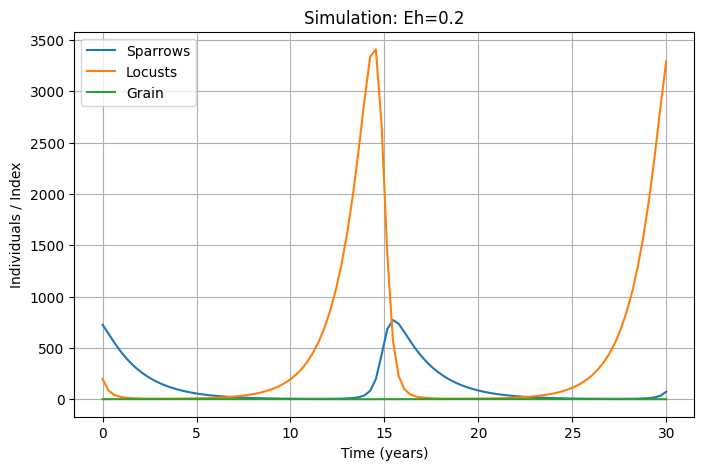

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         724.870 |         197.546 |           0.163
1955  |         642.186 |          87.151 |           0.300
1956  |         556.771 |          43.746 |           0.400
1957  |         478.460 |          24.895 |           0.479
1958  |         409.513 |          15.848 |           0.543
1959  |         349.803 |          11.114 |           0.596
1960  |         298.473 |           8.489 |           0.642
1961  |         254.519 |           6.956 |           0.681
1962  |         216.958 |           6.068 |           0.716
1963  |         184.907 |           5.595 |           0.746
1964  |         157.575 |           5.385 |           0.773
1965  |         134.268 |           5.377 |           0.797

--- Simulation 21 with params [0.00885805 0.02438892 1.76564967 0.00318835 0.00296726 0.00833877
 0.08255662] ---


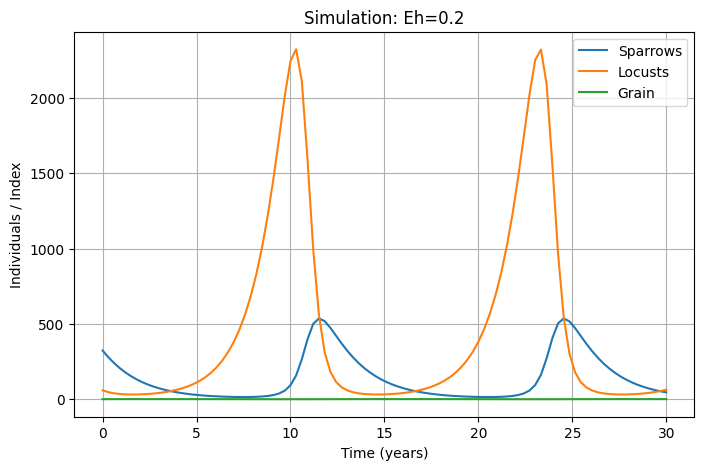

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         323.207 |          59.086 |           0.408
1955  |         279.376 |          46.639 |           0.496
1956  |         240.769 |          39.218 |           0.563
1957  |         207.131 |          34.837 |           0.613
1958  |         178.020 |          32.421 |           0.655
1959  |         152.919 |          31.437 |           0.688
1960  |         131.342 |          31.603 |           0.715
1961  |         112.834 |          32.751 |           0.736
1962  |          96.977 |          34.807 |           0.752
1963  |          83.406 |          37.814 |           0.762
1964  |          71.814 |          41.892 |           0.769
1965  |          61.927 |          47.200 |           0.771

--- Simulation 22 with params [0.00833283 0.03516089 1.11534643 0.00779304 0.00913501 0.00724302
 0.05290628] ---


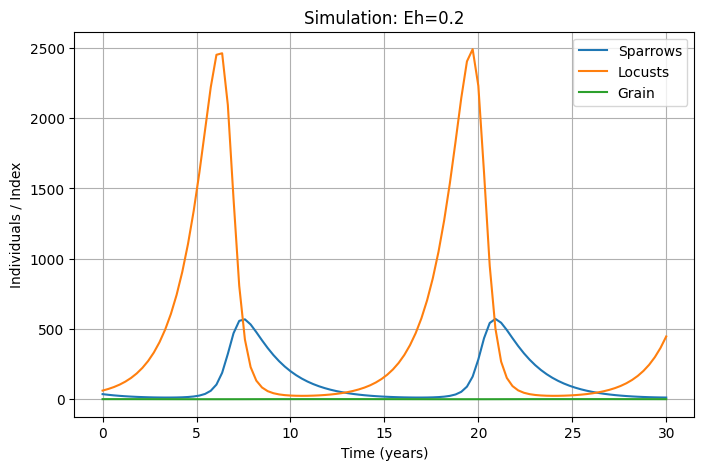

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          36.269 |          61.630 |           0.563
1955  |          31.490 |          72.939 |           0.619
1956  |          27.446 |          86.899 |           0.648
1957  |          24.034 |         104.118 |           0.653
1958  |          21.168 |         125.342 |           0.643
1959  |          18.778 |         151.491 |           0.619
1960  |          16.805 |         183.703 |           0.584
1961  |          15.204 |         223.368 |           0.540
1962  |          13.940 |         272.182 |           0.492
1963  |          12.993 |         332.223 |           0.440
1964  |          12.357 |         405.995 |           0.386
1965  |          12.048 |         496.504 |           0.334

--- Simulation 23 with params [0.0021856  0.05984587 1.67003789 0.00841045 0.00994328 0.00440567
 0.06942656] ---


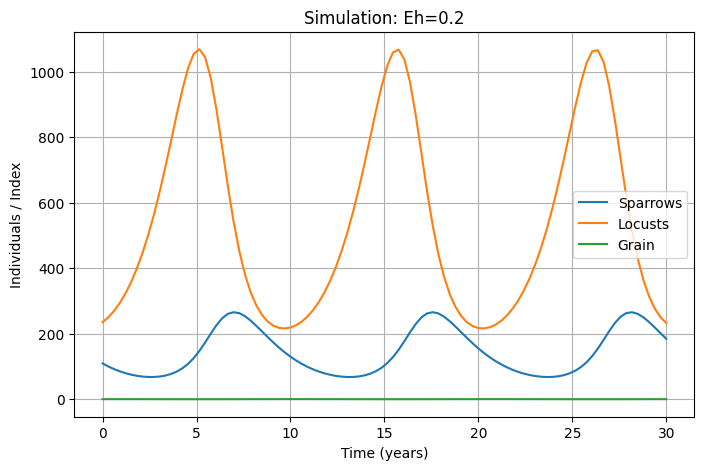

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         109.452 |         235.259 |           0.320
1955  |         100.213 |         250.062 |           0.376
1956  |          92.227 |         269.285 |           0.397
1957  |          85.434 |         293.249 |           0.399
1958  |          79.780 |         322.370 |           0.389
1959  |          75.223 |         357.132 |           0.372
1960  |          71.744 |         398.059 |           0.351
1961  |          69.349 |         445.654 |           0.327
1962  |          68.080 |         500.336 |           0.303
1963  |          68.026 |         562.294 |           0.279
1964  |          69.335 |         631.341 |           0.255
1965  |          72.235 |         706.633 |           0.232

--- Simulation 24 with params [0.00523441 0.05311481 1.3678212  0.00488444 0.00746593 0.00201093
 0.07407962] ---


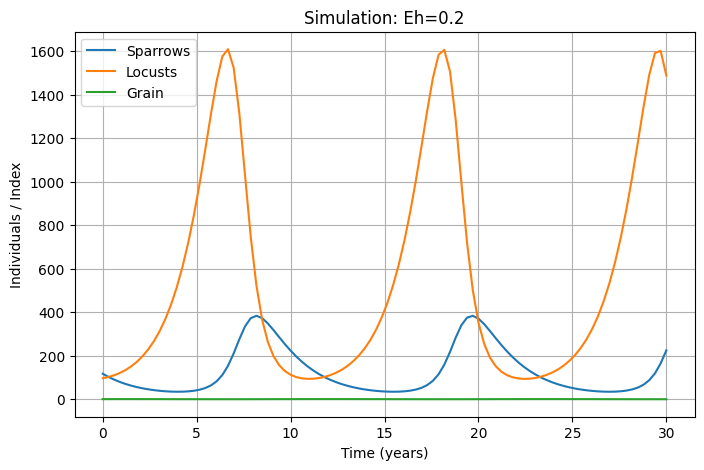

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         117.310 |          96.990 |           0.483
1955  |         102.857 |         102.286 |           0.537
1956  |          90.363 |         110.092 |           0.567
1957  |          79.607 |         120.599 |           0.580
1958  |          70.386 |         134.118 |           0.582
1959  |          62.521 |         151.092 |           0.573
1960  |          55.854 |         172.096 |           0.556
1961  |          50.252 |         197.848 |           0.533
1962  |          45.603 |         229.221 |           0.504
1963  |          41.821 |         267.269 |           0.470
1964  |          38.843 |         313.231 |           0.433
1965  |          36.633 |         368.542 |           0.393

--- Simulation 25 with params [0.00433304 0.07771813 1.49262915 0.00282656 0.00659365 0.00636097
 0.03841561] ---


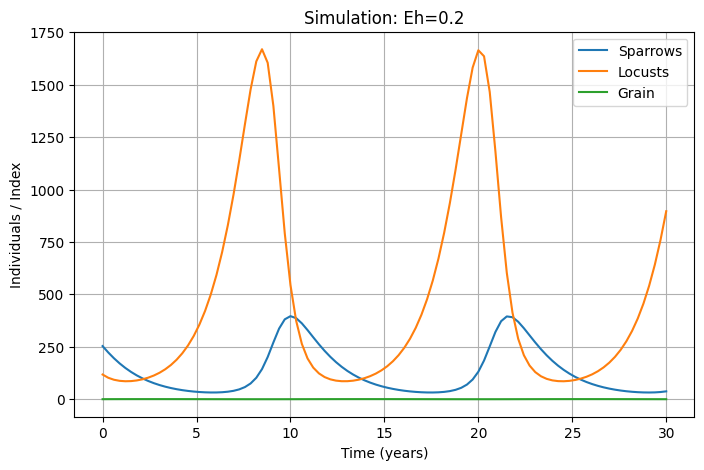

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         253.497 |         117.842 |           0.292
1955  |         222.943 |         102.355 |           0.405
1956  |         195.343 |          92.913 |           0.480
1957  |         170.788 |          87.736 |           0.532
1958  |         149.161 |          85.801 |           0.569
1959  |         130.250 |          86.520 |           0.595
1960  |         113.803 |          89.607 |           0.612
1961  |          99.559 |          94.992 |           0.622
1962  |          87.272 |         102.745 |           0.625
1963  |          76.711 |         113.061 |           0.622
1964  |          67.668 |         126.269 |           0.612
1965  |          59.960 |         142.818 |           0.597

--- Simulation 26 with params [0.0059601  0.06829938 2.40641798 0.00347596 0.00618362 0.00860696
 0.01455147] ---


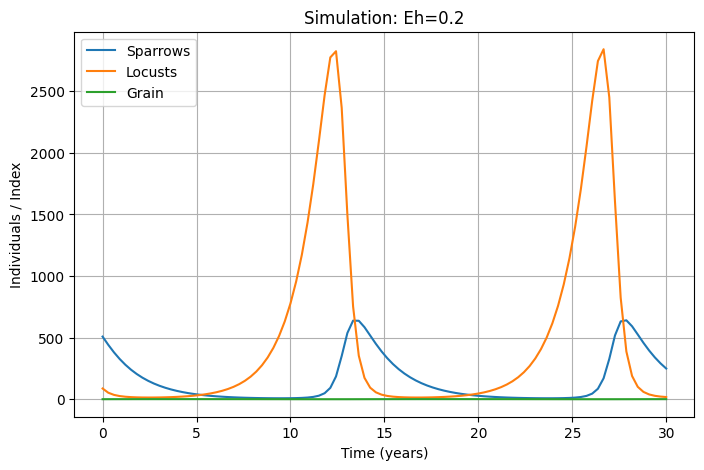

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         508.458 |          87.142 |           0.204
1955  |         441.599 |          52.874 |           0.352
1956  |         380.650 |          35.292 |           0.455
1957  |         326.812 |          25.730 |           0.532
1958  |         279.961 |          20.270 |           0.593
1959  |         239.522 |          17.041 |           0.643
1960  |         204.767 |          15.168 |           0.684
1961  |         174.981 |          14.199 |           0.719
1962  |         149.501 |          13.851 |           0.748
1963  |         127.718 |          13.983 |           0.772
1964  |         109.121 |          14.563 |           0.793
1965  |          93.265 |          15.584 |           0.810

--- Simulation 27 with params [0.00170719 0.04621461 0.57627834 0.00975208 0.00264743 0.00184877
 0.01754901] ---
Invalid result for case D, coexistence. 
Steady state no

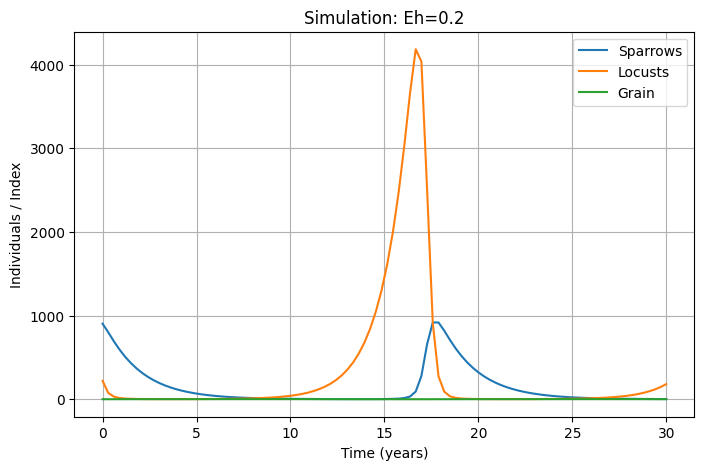

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         903.121 |         219.448 |           0.101
1955  |         799.916 |          74.928 |           0.263
1956  |         690.629 |          30.193 |           0.374
1957  |         591.312 |          14.264 |           0.457
1958  |         504.682 |           7.758 |           0.522
1959  |         430.160 |           4.766 |           0.576
1960  |         366.402 |           3.253 |           0.622
1961  |         311.986 |           2.424 |           0.662
1962  |         265.601 |           1.956 |           0.697
1963  |         226.090 |           1.682 |           0.729
1964  |         192.437 |           1.526 |           0.758
1965  |         163.793 |           1.454 |           0.784

--- Simulation 30 with params [0.00749952 0.09998623 1.58091986 0.00790396 0.00227718 0.00748337
 0.04458707] ---


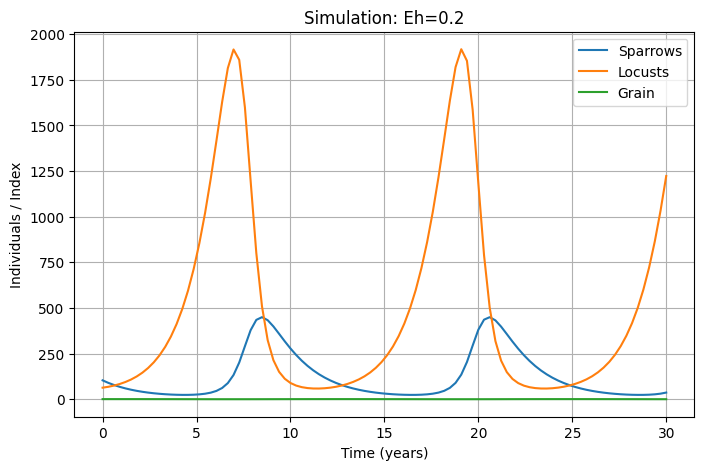

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         103.500 |          63.317 |           0.585
1955  |          89.822 |          68.146 |           0.626
1956  |          78.086 |          74.766 |           0.651
1957  |          68.041 |          83.394 |           0.661
1958  |          59.463 |          94.337 |           0.661
1959  |          52.160 |         108.004 |           0.653
1960  |          45.966 |         124.916 |           0.637
1961  |          40.739 |         145.732 |           0.614
1962  |          36.360 |         171.258 |           0.584
1963  |          32.731 |         202.473 |           0.549
1964  |          29.775 |         240.573 |           0.510
1965  |          27.433 |         286.993 |           0.467

--- Simulation 1 with params [0.00175676 0.0884758  0.80255192 0.00939043 0.00129332 0.00412384
 0.0830865 ] ---
Invalid result for case D, coexistence. 
Steady state not

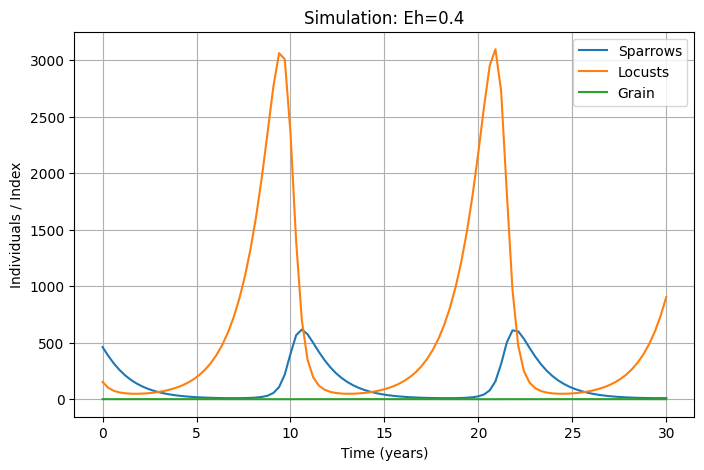

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         461.206 |         153.039 |           0.328
1955  |         383.428 |         100.637 |           0.405
1956  |         315.124 |          73.871 |           0.472
1957  |         257.434 |          59.711 |           0.530
1958  |         209.637 |          52.284 |           0.579
1959  |         170.441 |          48.871 |           0.620
1960  |         138.490 |          48.240 |           0.653
1961  |         112.547 |          49.732 |           0.680
1962  |          91.522 |          53.092 |           0.699
1963  |          74.529 |          58.363 |           0.711
1964  |          60.813 |          65.678 |           0.716
1965  |          49.740 |          75.268 |           0.714

--- Simulation 3 with params [0.00838751 0.06167032 1.32173033 0.00447792 0.00501927 0.00631604
 0.02538819] ---


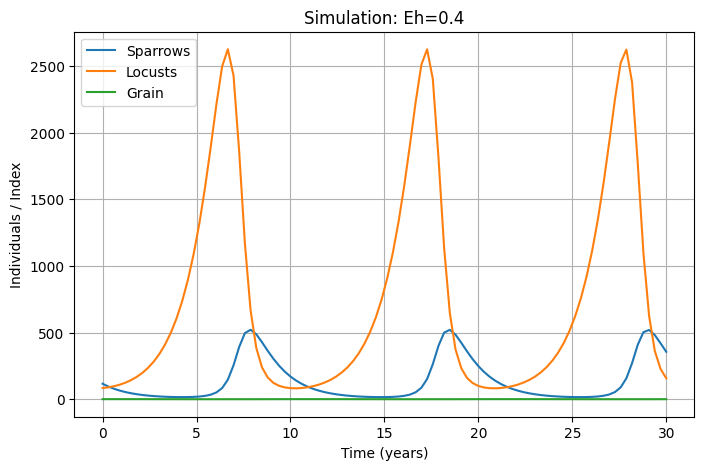

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         116.123 |          83.952 |           0.473
1955  |          95.447 |          89.136 |           0.540
1956  |          78.611 |          97.363 |           0.579
1957  |          64.940 |         108.836 |           0.598
1958  |          53.861 |         123.946 |           0.602
1959  |          44.905 |         143.302 |           0.594
1960  |          37.687 |         167.719 |           0.575
1961  |          31.892 |         198.235 |           0.547
1962  |          27.270 |         236.146 |           0.511
1963  |          23.618 |         283.069 |           0.469
1964  |          20.781 |         340.989 |           0.424
1965  |          18.645 |         412.304 |           0.376

--- Simulation 4 with params [9.85225698e-03 8.14503866e-02 2.23733699e+00 2.19938550e-03
 1.47959922e-03 8.86781431e-03 1.42458783e-02] ---


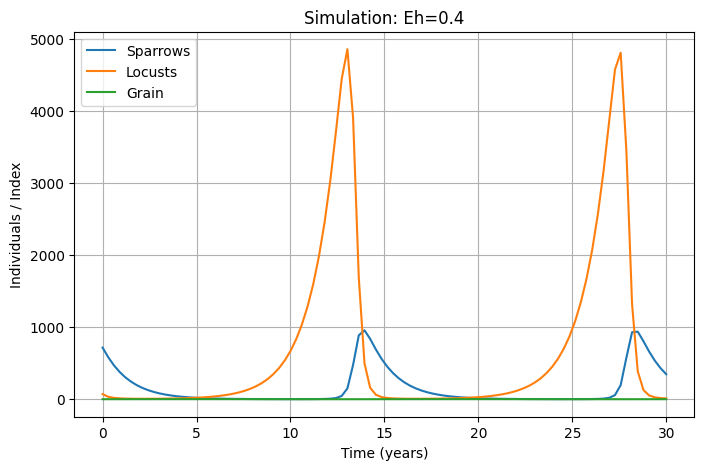

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         715.171 |          71.361 |           0.372
1955  |         581.262 |          33.371 |           0.442
1956  |         468.983 |          18.802 |           0.508
1957  |         377.262 |          12.370 |           0.567
1958  |         303.058 |           9.223 |           0.620
1959  |         243.284 |           7.628 |           0.667
1960  |         195.220 |           6.820 |           0.708
1961  |         156.636 |           6.524 |           0.745
1962  |         125.681 |           6.577 |           0.777
1963  |         100.810 |           6.900 |           0.805
1964  |          80.886 |           7.496 |           0.829
1965  |          64.953 |           8.381 |           0.849

--- Simulation 5 with params [8.11269781e-03 6.60464213e-02 1.59693594e+00 8.02835801e-03
 6.99139222e-03 1.42461959e-03 7.95791746e-02] ---


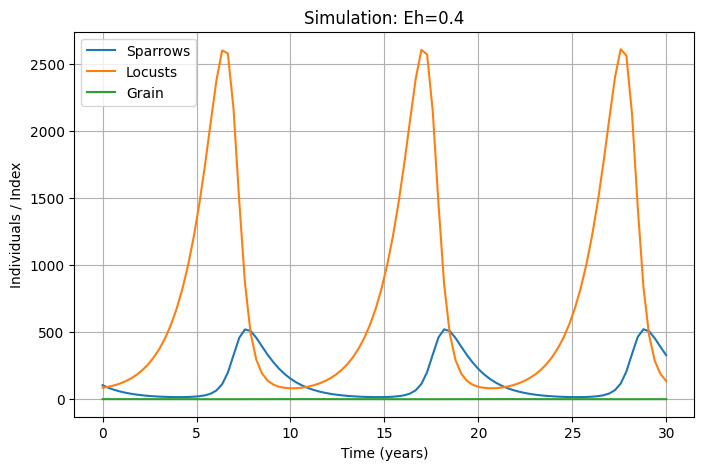

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         104.190 |          85.995 |           0.540
1955  |          85.712 |          92.810 |           0.581
1956  |          70.689 |         102.733 |           0.603
1957  |          58.507 |         116.095 |           0.609
1958  |          48.648 |         133.389 |           0.603
1959  |          40.691 |         155.322 |           0.588
1960  |          34.291 |         182.831 |           0.563
1961  |          29.168 |         217.095 |           0.530
1962  |          25.099 |         259.575 |           0.490
1963  |          21.910 |         312.069 |           0.446
1964  |          19.468 |         376.780 |           0.399
1965  |          17.679 |         456.366 |           0.351

--- Simulation 6 with params [4.47311458e-03 1.90143076e-02 2.30228896e+00 1.65417264e-03
 8.87648972e-03 4.80588373e-03 3.04772759e-02] ---


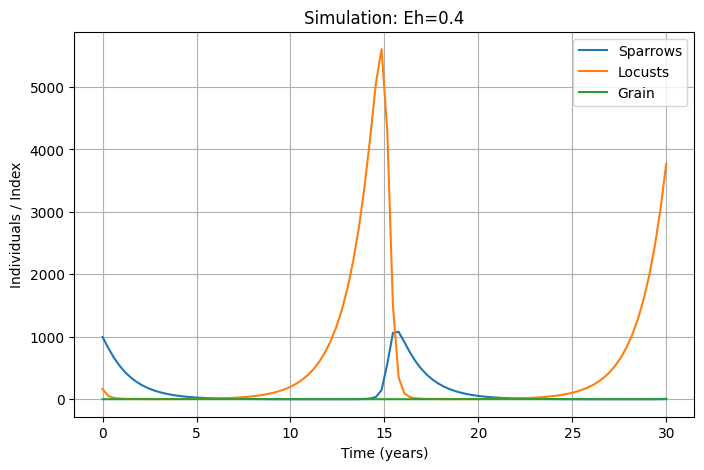

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         996.046 |         163.542 |           0.094
1955  |         820.832 |          51.427 |           0.265
1956  |         663.923 |          20.868 |           0.381
1957  |         534.027 |          10.527 |           0.468
1958  |         428.672 |           6.344 |           0.539
1959  |         343.798 |           4.407 |           0.599
1960  |         275.615 |           3.452 |           0.650
1961  |         220.906 |           2.961 |           0.696
1962  |         177.028 |           2.731 |           0.736
1963  |         141.881 |           2.682 |           0.771
1964  |         113.695 |           2.755 |           0.802
1965  |          91.079 |           2.938 |           0.829

--- Simulation 7 with params [0.00127699 0.06759285 0.74122777 0.00508891 0.00851165 0.00746204
 0.05164888] ---
Invalid result for case D, coexistence. 
Steady state not

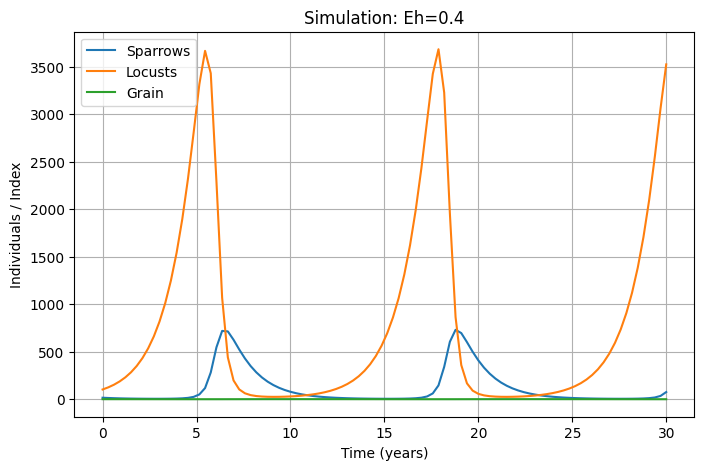

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          15.899 |         102.549 |           0.538
1955  |          13.176 |         124.973 |           0.574
1956  |          11.003 |         152.861 |           0.578
1957  |           9.275 |         187.526 |           0.560
1958  |           7.910 |         230.589 |           0.525
1959  |           6.846 |         284.061 |           0.479
1960  |           6.033 |         350.430 |           0.427
1961  |           5.437 |         432.764 |           0.373
1962  |           5.038 |         534.846 |           0.319
1963  |           4.833 |         661.310 |           0.269
1964  |           4.838 |         817.804 |           0.224
1965  |           5.105 |        1011.132 |           0.185

--- Simulation 9 with params [1.42202160e-03 4.48653425e-02 1.80689704e+00 7.40643526e-03
 7.55259509e-03 8.57691672e-03 3.44276116e-02] ---


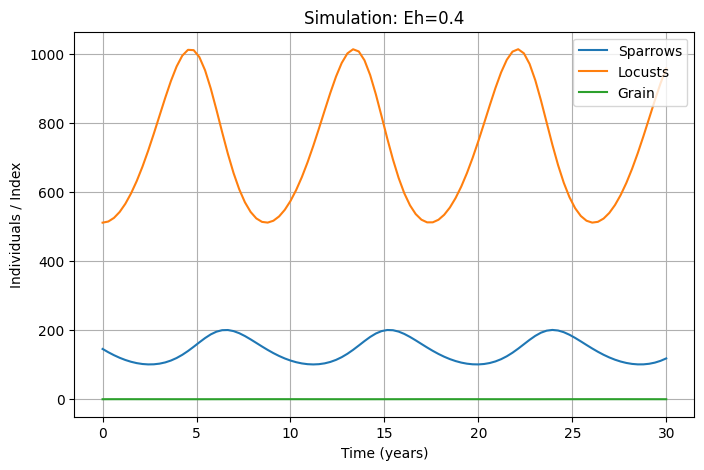

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         145.540 |         510.829 |           0.154
1955  |         136.093 |         514.128 |           0.232
1956  |         127.526 |         524.571 |           0.257
1957  |         120.001 |         541.800 |           0.261
1958  |         113.624 |         565.525 |           0.258
1959  |         108.465 |         595.475 |           0.251
1960  |         104.579 |         631.326 |           0.242
1961  |         102.019 |         672.619 |           0.232
1962  |         100.849 |         718.645 |           0.221
1963  |         101.152 |         768.335 |           0.210
1964  |         103.033 |         820.114 |           0.199
1965  |         106.614 |         871.783 |           0.189

--- Simulation 10 with params [0.00730696 0.02134686 1.06119294 0.00883186 0.00535401 0.0066945
 0.07081867] ---


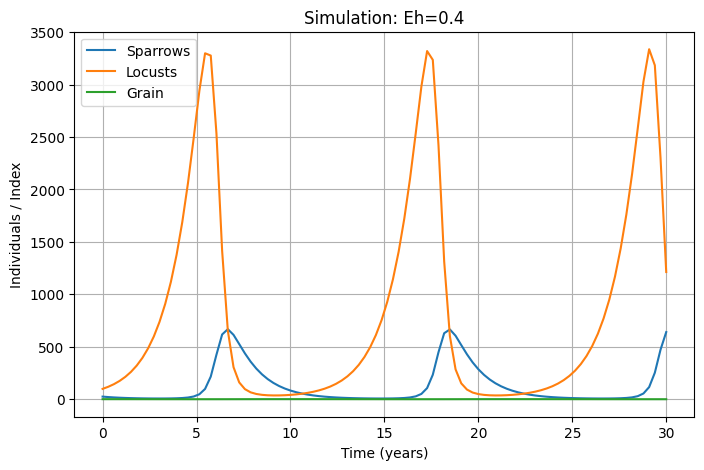

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          24.952 |          98.733 |           0.557
1955  |          20.647 |         118.830 |           0.588
1956  |          17.202 |         143.856 |           0.591
1957  |          14.454 |         174.969 |           0.574
1958  |          12.273 |         213.604 |           0.542
1959  |          10.558 |         261.536 |           0.498
1960  |           9.231 |         320.963 |           0.448
1961  |           8.235 |         394.582 |           0.395
1962  |           7.531 |         485.712 |           0.342
1963  |           7.103 |         598.401 |           0.291
1964  |           6.959 |         737.557 |           0.244
1965  |           7.144 |         909.052 |           0.203

--- Simulation 11 with params [3.27417686e-03 9.06846973e-02 2.02904857e+00 6.11932447e-03
 9.26258404e-03 1.16850412e-03 1.27195599e-02] ---


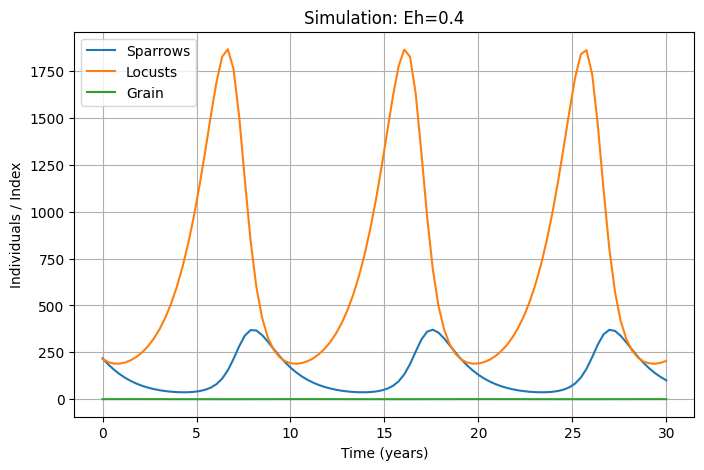

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         217.901 |         215.505 |           0.306
1955  |         185.705 |         197.833 |           0.377
1956  |         157.668 |         190.097 |           0.420
1957  |         133.712 |         189.990 |           0.447
1958  |         113.504 |         196.339 |           0.462
1959  |          96.625 |         208.666 |           0.467
1960  |          82.638 |         227.001 |           0.463
1961  |          71.136 |         251.761 |           0.451
1962  |          61.763 |         283.656 |           0.432
1963  |          54.211 |         323.699 |           0.407
1964  |          48.230 |         373.191 |           0.379
1965  |          43.629 |         433.702 |           0.346

--- Simulation 12 with params [6.88687684e-03 8.38991809e-02 1.22216445e+00 6.02264398e-03
 1.01574413e-03 1.84065998e-03 4.50820919e-02] ---


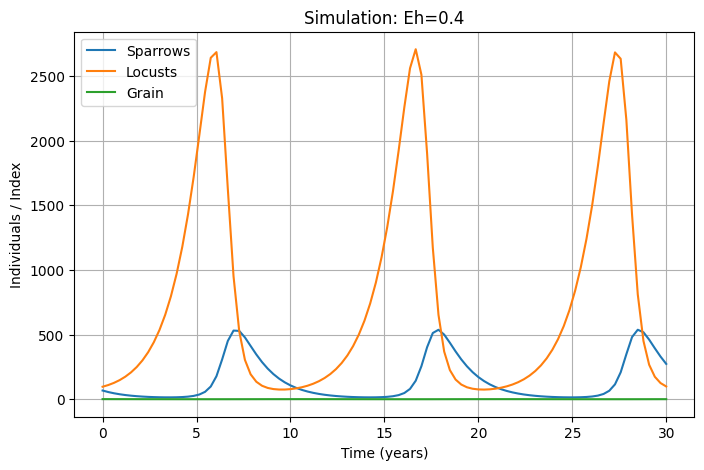

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          67.327 |          96.709 |           0.802
1955  |          55.620 |         109.790 |           0.738
1956  |          46.156 |         126.649 |           0.687
1957  |          38.525 |         147.994 |           0.643
1958  |          32.389 |         174.744 |           0.599
1959  |          27.479 |         208.054 |           0.556
1960  |          23.578 |         249.369 |           0.509
1961  |          20.514 |         300.462 |           0.461
1962  |          18.159 |         363.509 |           0.411
1963  |          16.419 |         441.147 |           0.361
1964  |          15.239 |         536.550 |           0.313
1965  |          14.605 |         653.484 |           0.267

--- Simulation 13 with params [6.17397460e-03 1.12940148e-02 1.96312796e+00 3.10535394e-03
 5.71520768e-04 9.18116129e-03 8.55568459e-02] ---


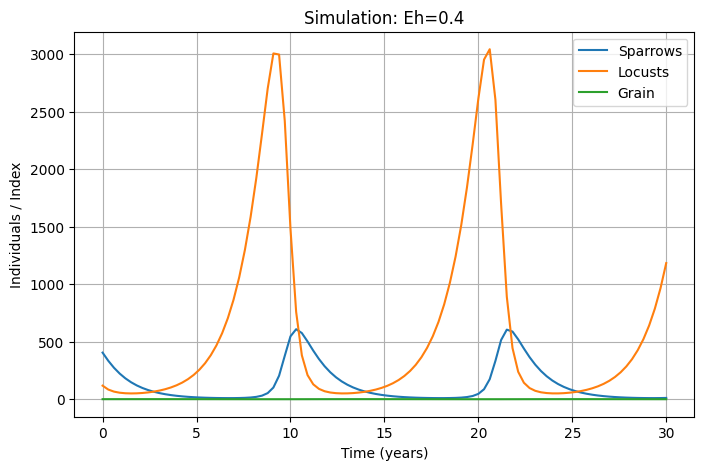

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         404.977 |         117.988 |           0.432
1955  |         334.180 |          84.054 |           0.478
1956  |         273.670 |          66.148 |           0.527
1957  |         223.219 |          56.605 |           0.572
1958  |         181.685 |          51.954 |           0.611
1959  |         147.745 |          50.462 |           0.644
1960  |         120.134 |          51.354 |           0.670
1961  |          97.745 |          54.300 |           0.691
1962  |          79.618 |          59.166 |           0.704
1963  |          64.964 |          66.075 |           0.710
1964  |          53.144 |          75.306 |           0.709
1965  |          43.618 |          87.224 |           0.702

--- Simulation 14 with params [0.00378672 0.03681174 2.43761211 0.00484052 0.00831493 0.00715505
 0.09433575] ---


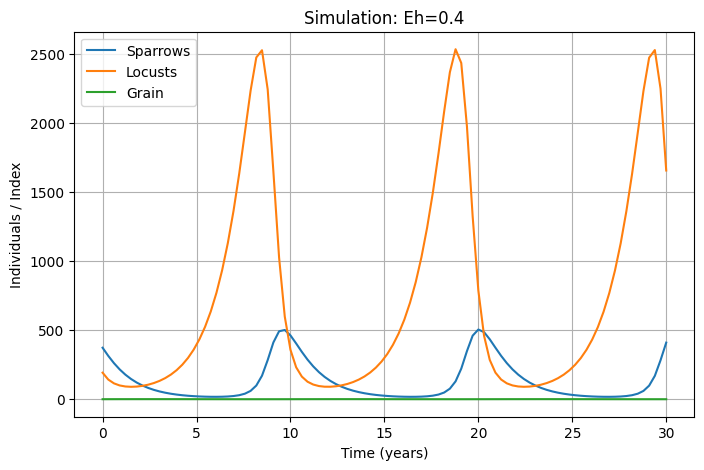

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         372.533 |         191.882 |           0.183
1955  |         313.558 |         142.232 |           0.319
1956  |         260.943 |         114.739 |           0.409
1957  |         215.796 |          99.693 |           0.474
1958  |         177.866 |          92.255 |           0.524
1959  |         146.395 |          89.926 |           0.561
1960  |         120.475 |          91.579 |           0.587
1961  |          99.244 |          96.730 |           0.605
1962  |          81.927 |         105.131 |           0.614
1963  |          67.837 |         116.944 |           0.613
1964  |          56.406 |         132.639 |           0.605
1965  |          47.157 |         152.833 |           0.589

--- Simulation 15 with params [7.77489506e-03 7.31471075e-04 1.73159584e+00 9.89434657e-03
 9.77145913e-03 2.94800881e-03 4.85331893e-02] ---


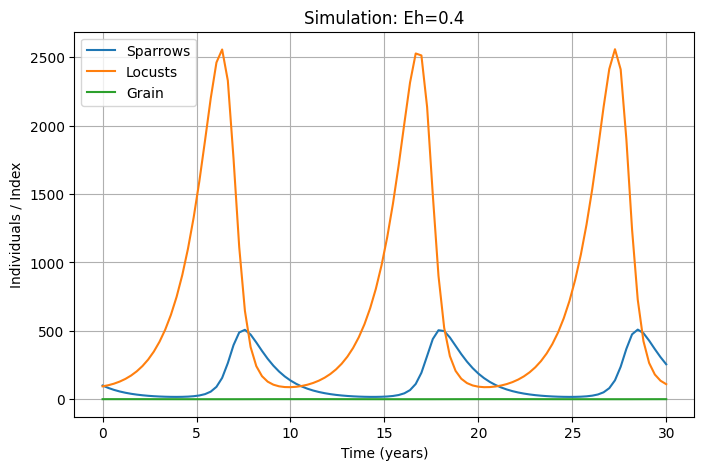

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         100.192 |          94.279 |           0.443
1955  |          82.646 |         102.297 |           0.515
1956  |          68.373 |         113.699 |           0.556
1957  |          56.793 |         128.865 |           0.572
1958  |          47.421 |         148.378 |           0.572
1959  |          39.861 |         173.043 |           0.559
1960  |          33.789 |         203.898 |           0.534
1961  |          28.942 |         242.242 |           0.501
1962  |          25.114 |         289.683 |           0.461
1963  |          22.144 |         348.202 |           0.416
1964  |          19.913 |         420.190 |           0.370
1965  |          18.346 |         508.518 |           0.323

--- Simulation 16 with params [0.0020532  0.07367648 0.64169224 0.00951808 0.00650127 0.00351932
 0.06927759] ---
Invalid result for case D, coexistence. 
Steady state no

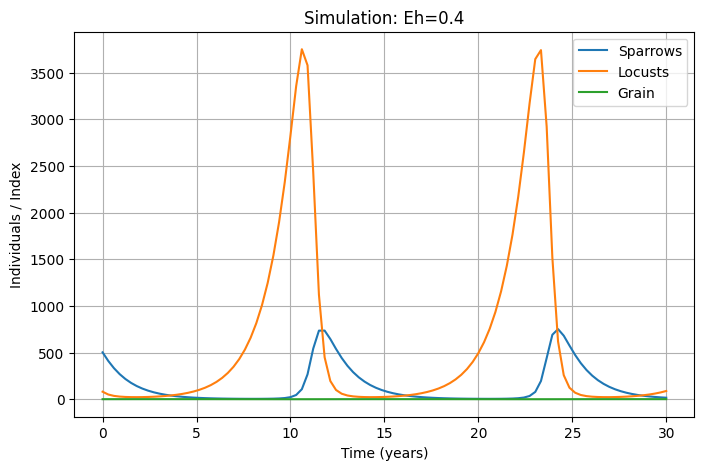

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         502.551 |          80.626 |           0.334
1955  |         410.248 |          50.381 |           0.431
1956  |         332.732 |          35.800 |           0.509
1957  |         268.999 |          28.305 |           0.573
1958  |         217.109 |          24.453 |           0.626
1959  |         175.079 |          22.647 |           0.671
1960  |         141.139 |          22.230 |           0.708
1961  |         113.795 |          22.877 |           0.740
1962  |          91.762 |          24.399 |           0.764
1963  |          74.029 |          26.813 |           0.783
1964  |          59.799 |          30.213 |           0.797
1965  |          48.375 |          34.717 |           0.805

--- Simulation 18 with params [0.00261069 0.04221778 1.53203099 0.00536906 0.0020267  0.0031843
 0.07401626] ---


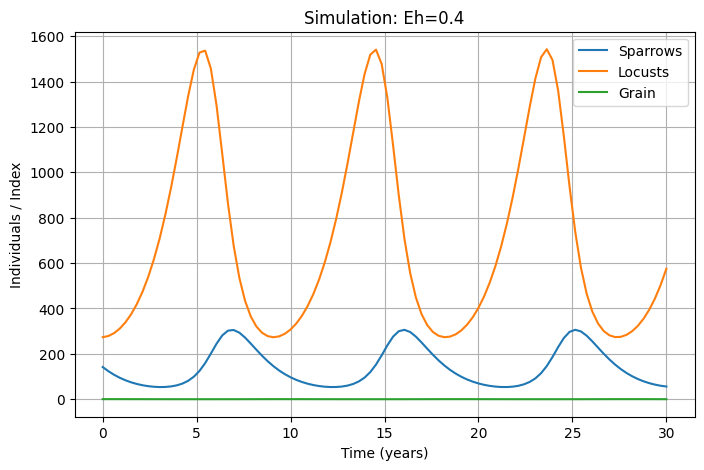

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         141.894 |         273.403 |           0.463
1955  |         123.508 |         278.643 |           0.428
1956  |         107.799 |         291.408 |           0.410
1957  |          94.557 |         311.505 |           0.395
1958  |          83.544 |         339.154 |           0.380
1959  |          74.524 |         374.893 |           0.361
1960  |          67.292 |         419.522 |           0.340
1961  |          61.679 |         474.045 |           0.316
1962  |          57.570 |         539.610 |           0.290
1963  |          54.914 |         617.396 |           0.263
1964  |          53.736 |         708.457 |           0.236
1965  |          54.168 |         813.428 |           0.211

--- Simulation 19 with params [0.00294719 0.07126899 1.26174998 0.00234192 0.0059629  0.00243035
 0.06327501] ---


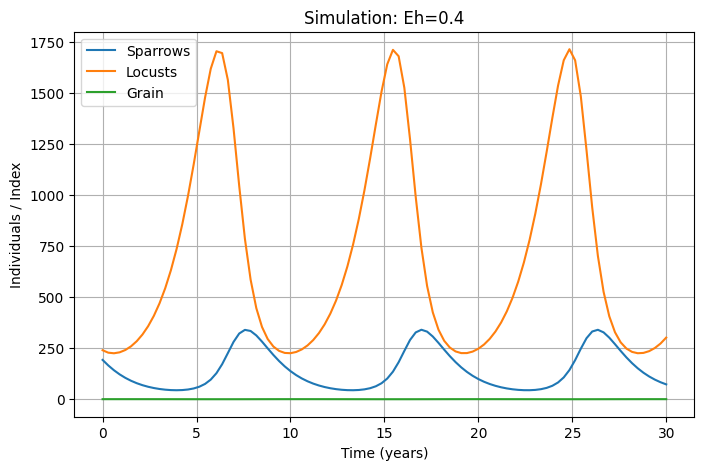

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         192.582 |         239.972 |           0.366
1955  |         165.500 |         227.998 |           0.397
1956  |         141.908 |         225.112 |           0.418
1957  |         121.714 |         229.761 |           0.429
1958  |         104.656 |         241.190 |           0.433
1959  |          90.390 |         259.252 |           0.429
1960  |          78.575 |         284.241 |           0.418
1961  |          68.897 |         316.756 |           0.401
1962  |          61.089 |         357.664 |           0.379
1963  |          54.921 |         408.136 |           0.353
1964  |          50.217 |         469.573 |           0.324
1965  |          46.866 |         543.560 |           0.293

--- Simulation 20 with params [0.00601973 0.0963919  2.12629165 0.00567618 0.00632226 0.00959418
 0.03126418] ---


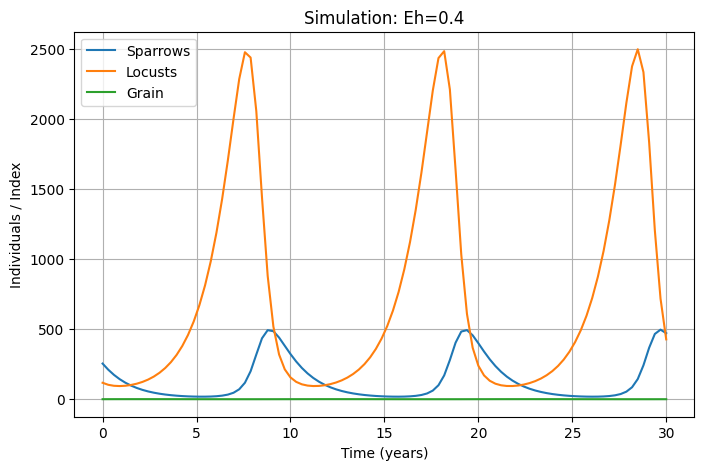

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         254.614 |         117.537 |           0.268
1955  |         210.759 |         103.003 |           0.391
1956  |         173.899 |          95.967 |           0.472
1957  |         143.300 |          94.074 |           0.527
1958  |         118.089 |          96.200 |           0.564
1959  |          97.431 |         101.842 |           0.587
1960  |          80.562 |         110.898 |           0.599
1961  |          66.835 |         123.605 |           0.600
1962  |          55.695 |         140.393 |           0.592
1963  |          46.680 |         161.882 |           0.575
1964  |          39.413 |         188.962 |           0.551
1965  |          33.586 |         222.753 |           0.519

--- Simulation 21 with params [0.00660178 0.03023507 1.66789603 0.00381912 0.00549037 0.00829804
 0.0552633 ] ---


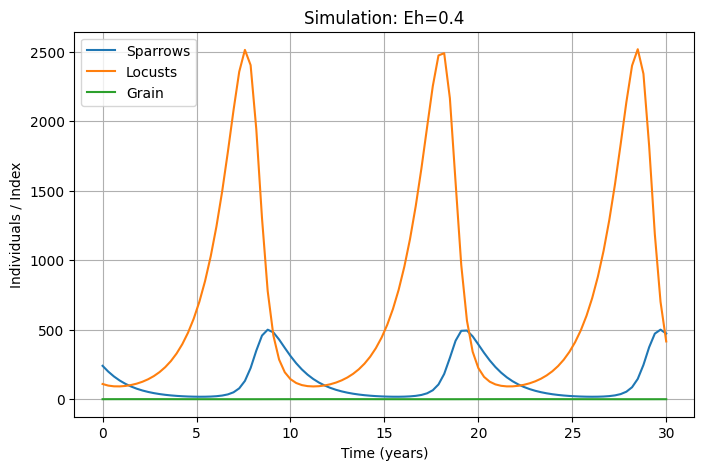

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         240.390 |         109.663 |           0.310
1955  |         198.606 |          98.039 |           0.420
1956  |         163.674 |          92.905 |           0.492
1957  |         134.778 |          92.377 |           0.542
1958  |         111.028 |          95.579 |           0.575
1959  |          91.601 |         102.180 |           0.595
1960  |          75.761 |         112.167 |           0.604
1961  |          62.884 |         125.834 |           0.603
1962  |          52.446 |         143.699 |           0.592
1963  |          44.010 |         166.449 |           0.573
1964  |          37.218 |         195.011 |           0.546
1965  |          31.781 |         230.584 |           0.513

--- Simulation 22 with params [0.0094165  0.01622207 1.87304973 0.00695846 0.00383473 0.00207123
 0.03918691] ---


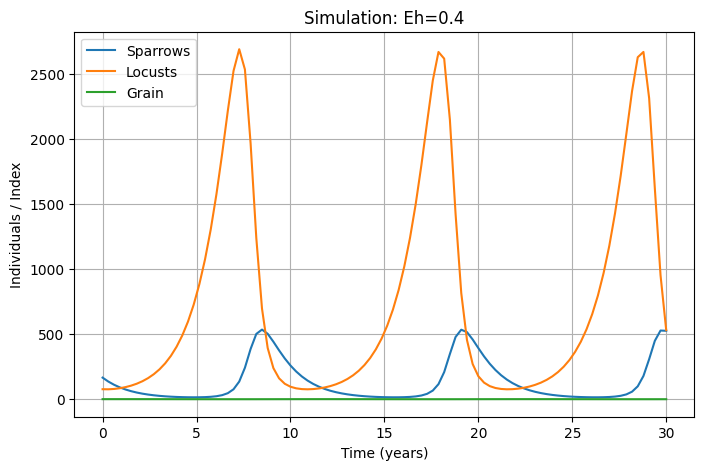

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         165.842 |          76.918 |           0.557
1955  |         135.901 |          76.264 |           0.593
1956  |         111.390 |          78.787 |           0.618
1957  |          91.409 |          84.306 |           0.635
1958  |          75.174 |          92.740 |           0.643
1959  |          62.009 |         104.168 |           0.642
1960  |          51.353 |         119.110 |           0.633
1961  |          42.751 |         138.208 |           0.616
1962  |          35.823 |         162.272 |           0.592
1963  |          30.263 |         192.307 |           0.560
1964  |          25.828 |         229.620 |           0.522
1965  |          22.322 |         275.819 |           0.479

--- Simulation 23 with params [0.00864595 0.04896838 1.11028294 0.00307873 0.00955778 0.00548415
 0.04275094] ---


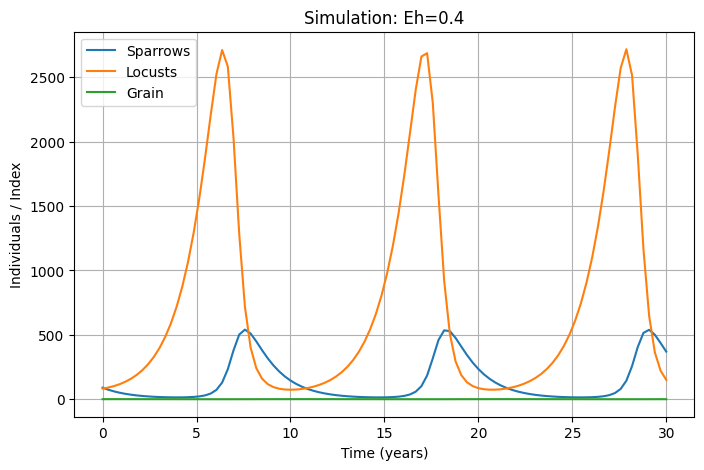

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          89.916 |          82.368 |           0.433
1955  |          73.905 |          90.667 |           0.517
1956  |          60.927 |         102.012 |           0.565
1957  |          50.427 |         116.832 |           0.587
1958  |          41.949 |         135.732 |           0.591
1959  |          35.122 |         159.521 |           0.579
1960  |          29.645 |         189.231 |           0.555
1961  |          25.275 |         226.148 |           0.521
1962  |          21.820 |         271.864 |           0.480
1963  |          19.130 |         328.345 |           0.434
1964  |          17.093 |         397.979 |           0.386
1965  |          15.637 |         483.654 |           0.337

--- Simulation 24 with params [2.44153602e-03 2.58352076e-02 2.40330562e+00 1.00954957e-03
 7.75095227e-03 2.67886116e-03 2.07110429e-02] ---


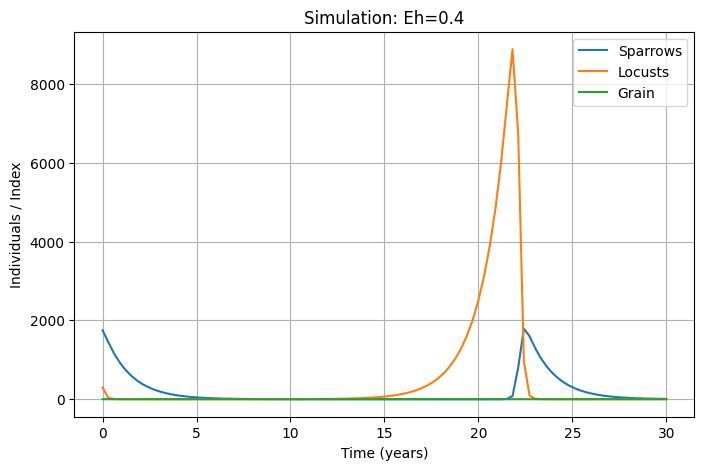

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |        1747.117 |         299.668 |           0.065
1955  |        1449.277 |          32.891 |           0.226
1956  |        1165.769 |           5.692 |           0.328
1957  |         934.329 |           1.454 |           0.403
1958  |         748.352 |           0.509 |           0.464
1959  |         599.296 |           0.229 |           0.518
1960  |         479.903 |           0.127 |           0.568
1961  |         384.286 |           0.082 |           0.615
1962  |         307.721 |           0.061 |           0.658
1963  |         246.392 |           0.050 |           0.699
1964  |         197.299 |           0.044 |           0.736
1965  |         158.005 |           0.042 |           0.771

--- Simulation 25 with params [0.00509336 0.09791774 0.88570857 0.00716278 0.00422743 0.00770834
 0.07895352] ---


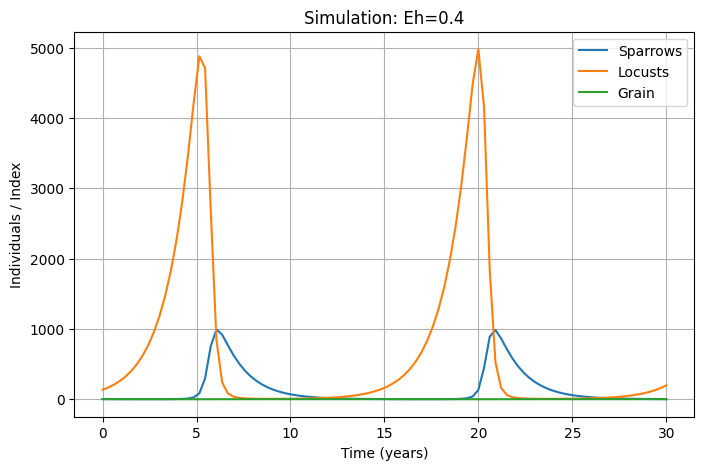

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |           2.592 |         134.593 |           0.488
1955  |           2.172 |         167.061 |           0.521
1956  |           1.840 |         207.478 |           0.518
1957  |           1.581 |         257.789 |           0.490
1958  |           1.381 |         320.410 |           0.446
1959  |           1.233 |         398.348 |           0.394
1960  |           1.130 |         495.336 |           0.339
1961  |           1.070 |         616.016 |           0.286
1962  |           1.055 |         766.142 |           0.238
1963  |           1.095 |         952.836 |           0.196
1964  |           1.211 |        1184.889 |           0.160
1965  |           1.448 |        1473.074 |           0.130

--- Simulation 26 with params [0.00555108 0.07988941 0.56681795 0.00363361 0.00367858 0.00573351
 0.06583199] ---
Invalid result for case D, coexistence. 
Steady state no

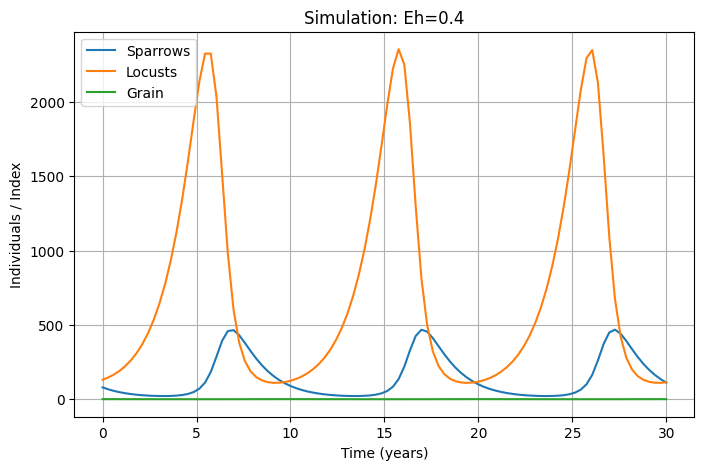

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          79.742 |         131.175 |           0.480
1955  |          66.586 |         146.308 |           0.516
1956  |          55.896 |         166.153 |           0.527
1957  |          47.243 |         191.465 |           0.521
1958  |          40.275 |         223.251 |           0.502
1959  |          34.707 |         262.787 |           0.472
1960  |          30.311 |         311.664 |           0.435
1961  |          26.911 |         371.812 |           0.395
1962  |          24.381 |         445.558 |           0.352
1963  |          22.641 |         535.660 |           0.309
1964  |          21.671 |         645.306 |           0.267
1965  |          21.515 |         778.069 |           0.228

--- Simulation 28 with params [3.64071214e-03 5.44428489e-02 5.30114520e-01 4.28261371e-03
 1.14969263e-04 5.86867002e-03 9.98064317e-02] ---
Invalid result for case D, c

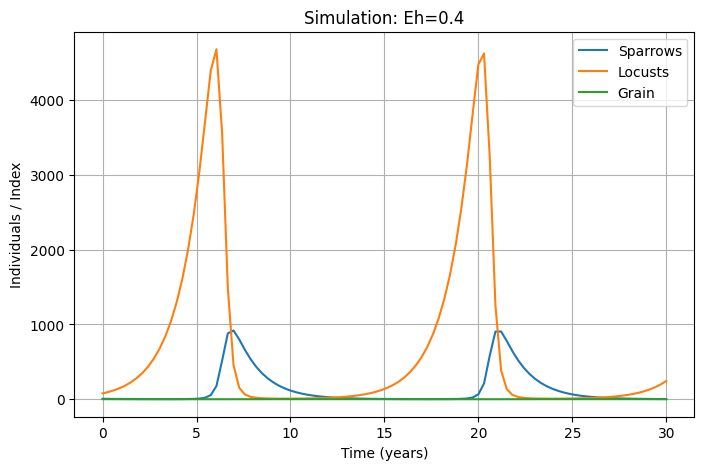

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |           5.953 |          78.217 |           0.645
1955  |           4.894 |          96.641 |           0.662
1956  |           4.049 |         119.575 |           0.656
1957  |           3.376 |         148.122 |           0.632
1958  |           2.842 |         183.652 |           0.595
1959  |           2.422 |         227.866 |           0.547
1960  |           2.094 |         282.887 |           0.492
1961  |           1.846 |         351.345 |           0.433
1962  |           1.664 |         436.512 |           0.374
1963  |           1.545 |         542.446 |           0.318
1964  |           1.486 |         674.181 |           0.266
1965  |           1.495 |         837.939 |           0.220

--- Simulation 30 with params [0.00407504 0.05699842 2.16976374 0.00765329 0.00237768 0.00980376
 0.01617348] ---


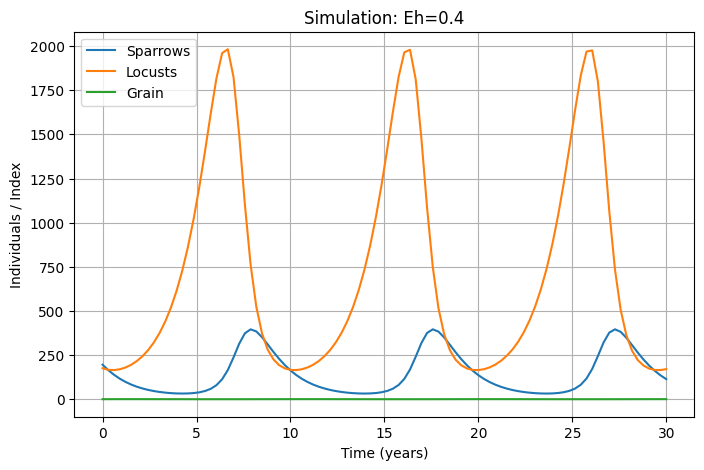

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         195.371 |         175.567 |           0.314
1955  |         164.730 |         166.584 |           0.397
1956  |         138.678 |         164.996 |           0.446
1957  |         116.800 |         169.450 |           0.474
1958  |          98.589 |         179.383 |           0.488
1959  |          83.536 |         194.730 |           0.491
1960  |          71.173 |         215.814 |           0.483
1961  |          61.085 |         243.276 |           0.467
1962  |          52.923 |         278.037 |           0.444
1963  |          46.395 |         321.309 |           0.415
1964  |          41.270 |         374.597 |           0.383
1965  |          37.374 |         439.709 |           0.347

--- Simulation 1 with params [1.75066382e-03 3.01875976e-02 2.21456188e+00 5.28377334e-03
 1.74947371e-03 1.53680828e-03 9.84138340e-02] ---


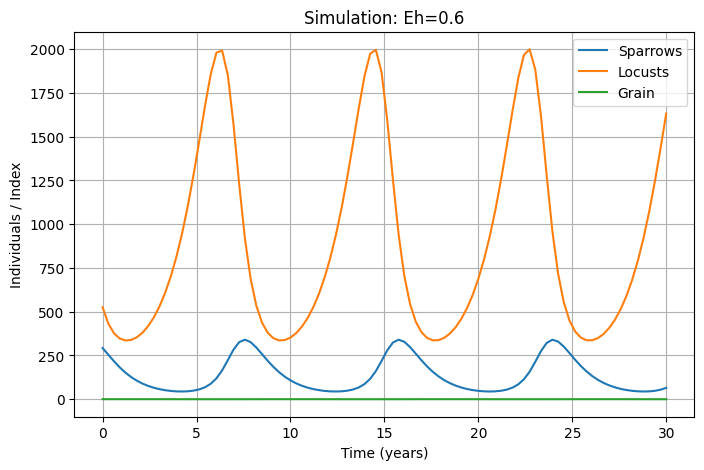

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         292.735 |         525.699 |           0.431
1955  |         254.793 |         432.387 |           0.328
1956  |         216.906 |         376.885 |           0.317
1957  |         182.326 |         347.137 |           0.328
1958  |         152.329 |         335.793 |           0.340
1959  |         127.114 |         338.691 |           0.349
1960  |         106.365 |         353.695 |           0.350
1961  |          89.561 |         380.001 |           0.345
1962  |          76.147 |         417.684 |           0.332
1963  |          65.604 |         467.487 |           0.314
1964  |          57.493 |         530.649 |           0.292
1965  |          51.474 |         608.802 |           0.266

--- Simulation 2 with params [0.00235899 0.07914062 1.02392419 0.00669052 0.00442231 0.00123319
 0.01113881] ---


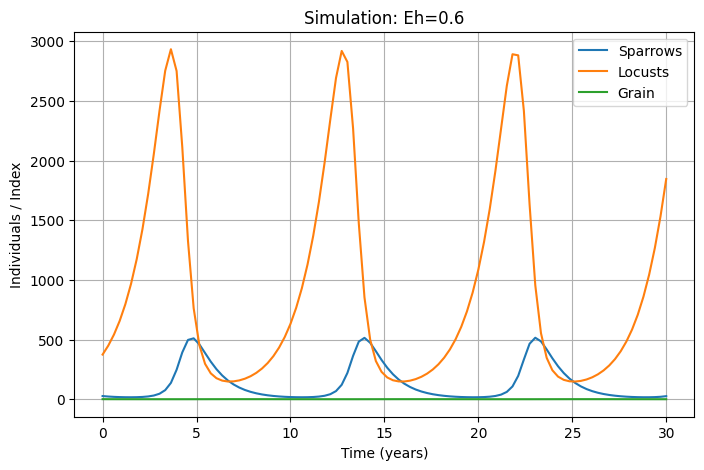

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          26.532 |         374.404 |           0.633
1955  |          22.645 |         449.405 |           0.444
1956  |          19.823 |         542.166 |           0.339
1957  |          17.904 |         656.416 |           0.274
1958  |          16.804 |         796.557 |           0.227
1959  |          16.531 |         967.631 |           0.190
1960  |          17.220 |        1175.107 |           0.159
1961  |          19.221 |        1424.256 |           0.133
1962  |          23.294 |        1718.539 |           0.111
1963  |          31.071 |        2055.697 |           0.093
1964  |          46.114 |        2418.415 |           0.079
1965  |          76.229 |        2753.277 |           0.069

--- Simulation 3 with params [2.00428009e-03 1.39970576e-02 1.18109720e+00 9.66475055e-03
 9.61089820e-04 6.63117795e-03 7.57802238e-02] ---


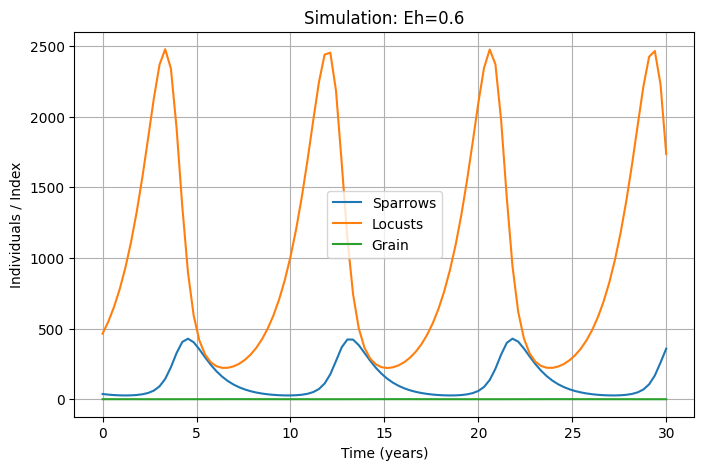

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          37.069 |         463.972 |           0.243
1955  |          32.554 |         548.377 |           0.267
1956  |          29.412 |         651.892 |           0.252
1957  |          27.511 |         777.905 |           0.224
1958  |          26.839 |         930.095 |           0.193
1959  |          27.540 |        1112.071 |           0.165
1960  |          30.008 |        1326.556 |           0.140
1961  |          35.067 |        1573.635 |           0.119
1962  |          44.355 |        1847.076 |           0.102
1963  |          61.056 |        2126.919 |           0.089
1964  |          91.075 |        2366.279 |           0.079
1965  |         143.638 |        2476.145 |           0.074

--- Simulation 4 with params [0.00620939 0.00384646 1.23891709 0.001744   0.00542818 0.00457662
 0.04824958] ---


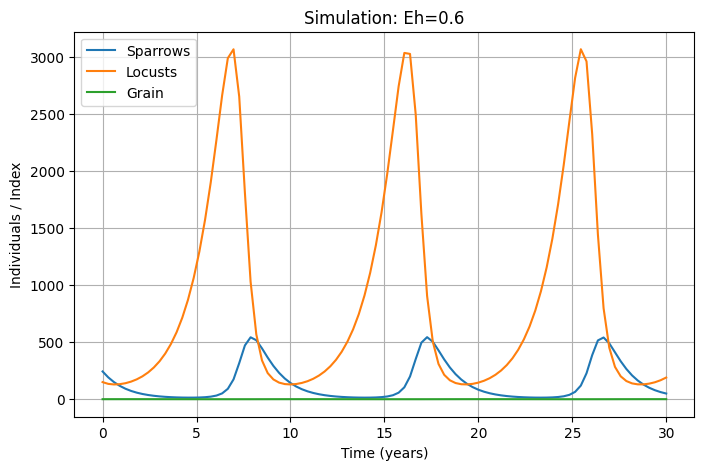

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         243.551 |         150.104 |           0.332
1955  |         191.587 |         134.621 |           0.416
1956  |         150.242 |         129.656 |           0.472
1957  |         117.783 |         132.066 |           0.508
1958  |          92.488 |         140.362 |           0.530
1959  |          72.871 |         154.402 |           0.538
1960  |          57.713 |         174.400 |           0.534
1961  |          46.029 |         200.898 |           0.520
1962  |          37.049 |         235.052 |           0.495
1963  |          30.172 |         278.364 |           0.462
1964  |          24.932 |         332.696 |           0.423
1965  |          20.989 |         400.332 |           0.380

--- Simulation 5 with params [0.00278054 0.0272147  1.89403435 0.00376444 0.00799292 0.00841745
 0.03463936] ---


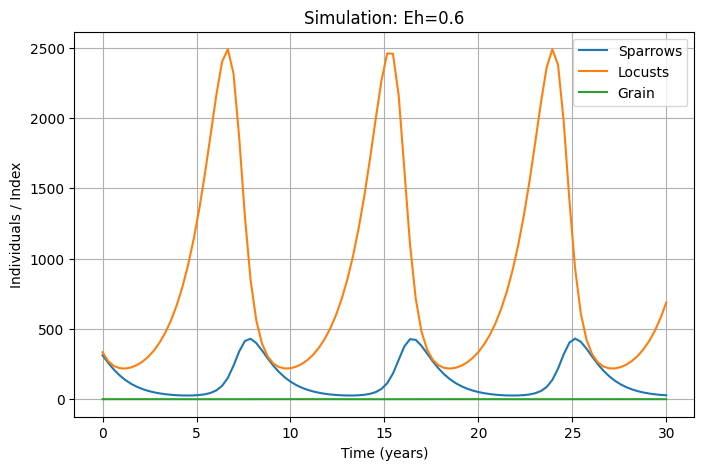

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         312.966 |         334.116 |           0.158
1955  |         258.231 |         270.183 |           0.275
1956  |         210.017 |         236.274 |           0.343
1957  |         169.569 |         220.990 |           0.388
1958  |         136.559 |         218.475 |           0.416
1959  |         110.054 |         225.986 |           0.432
1960  |          89.020 |         242.274 |           0.436
1961  |          72.460 |         267.150 |           0.430
1962  |          59.501 |         301.293 |           0.415
1963  |          49.436 |         345.788 |           0.392
1964  |          41.712 |         402.125 |           0.362
1965  |          35.877 |         472.432 |           0.328

--- Simulation 6 with params [0.00567477 0.07357627 1.90852621 0.00919674 0.00709708 0.00749013
 0.08881745] ---


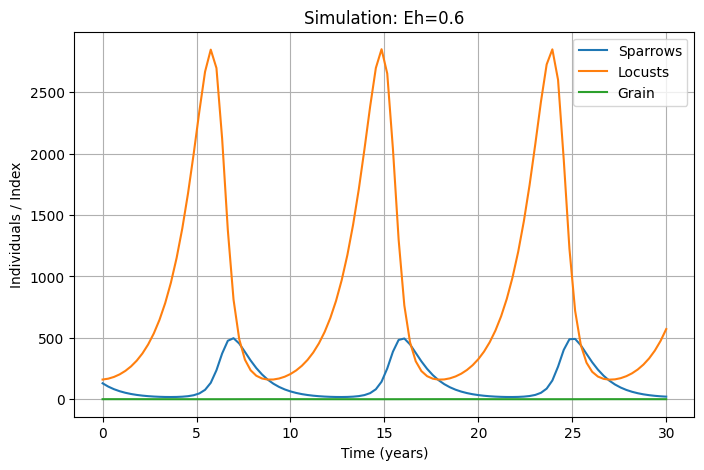

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         129.916 |         160.319 |           0.320
1955  |         102.879 |         167.555 |           0.408
1956  |          81.733 |         181.607 |           0.453
1957  |          65.277 |         202.492 |           0.471
1958  |          52.524 |         230.805 |           0.468
1959  |          42.680 |         267.595 |           0.452
1960  |          35.121 |         314.343 |           0.424
1961  |          29.364 |         372.983 |           0.389
1962  |          25.044 |         445.935 |           0.349
1963  |          21.892 |         536.167 |           0.307
1964  |          19.728 |         647.248 |           0.266
1965  |          18.454 |         783.374 |           0.227

--- Simulation 7 with params [0.00920571 0.02000807 0.60248627 0.0027551  0.0032992  0.00406917
 0.0723977 ] ---
Invalid result for case D, coexistence. 
Steady state not

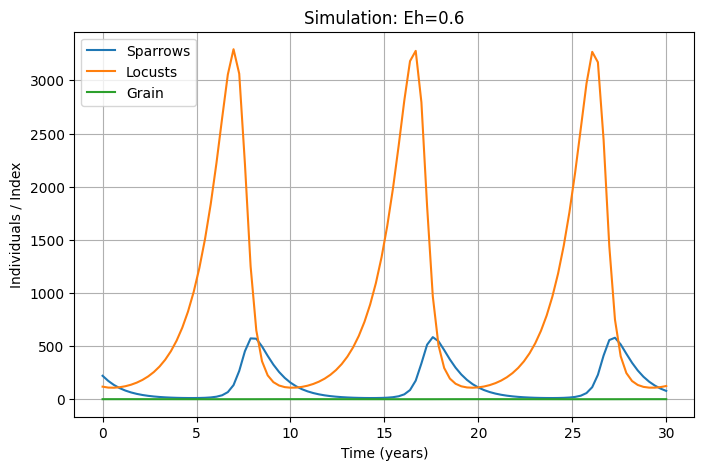

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         220.620 |         118.211 |           0.445
1955  |         172.068 |         109.466 |           0.496
1956  |         133.992 |         108.308 |           0.534
1957  |         104.398 |         112.923 |           0.560
1958  |          81.519 |         122.283 |           0.574
1959  |          63.882 |         136.526 |           0.577
1960  |          50.323 |         156.087 |           0.570
1961  |          39.908 |         181.655 |           0.552
1962  |          31.929 |         214.355 |           0.524
1963  |          25.836 |         255.649 |           0.490
1964  |          21.200 |         307.373 |           0.448
1965  |          17.702 |         371.822 |           0.402

--- Simulation 9 with params [1.31758086e-03 6.62478533e-02 2.31833769e+00 6.24455021e-03
 4.79533631e-03 2.46827774e-03 9.54259750e-02] ---


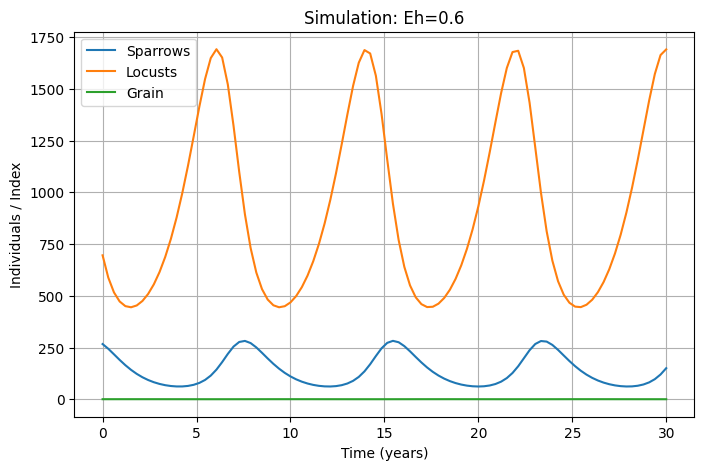

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         266.807 |         695.789 |           0.250
1955  |         244.012 |         588.140 |           0.234
1956  |         217.229 |         516.461 |           0.248
1957  |         190.065 |         472.604 |           0.266
1958  |         164.659 |         450.127 |           0.281
1959  |         142.057 |         444.636 |           0.290
1960  |         122.626 |         453.428 |           0.294
1961  |         106.343 |         475.070 |           0.292
1962  |          93.004 |         509.021 |           0.284
1963  |          82.333 |         555.393 |           0.271
1964  |          74.061 |         614.730 |           0.256
1965  |          67.970 |         687.831 |           0.236

--- Simulation 10 with params [1.07814203e-03 2.51807761e-03 1.51649555e+00 2.40735909e-03
 8.59153444e-03 4.79464745e-03 9.28118348e-02] ---


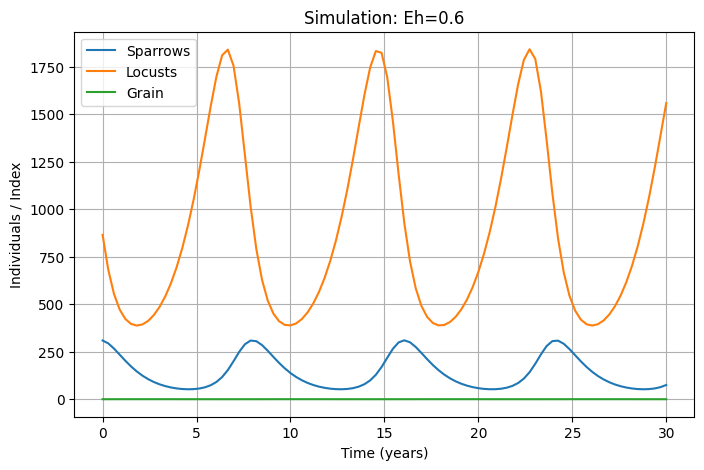

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         309.040 |         865.388 |           0.128
1955  |         293.957 |         681.315 |           0.184
1956  |         266.809 |         554.391 |           0.220
1957  |         234.693 |         472.198 |           0.251
1958  |         202.419 |         422.450 |           0.278
1959  |         172.612 |         396.258 |           0.299
1960  |         146.442 |         387.818 |           0.313
1961  |         124.199 |         393.742 |           0.320
1962  |         105.728 |         412.263 |           0.320
1963  |          90.676 |         442.734 |           0.313
1964  |          78.630 |         485.300 |           0.300
1965  |          69.203 |         540.653 |           0.282

--- Simulation 11 with params [0.00698298 0.0808978  0.74719453 0.006845   0.00277535 0.00355115
 0.0619287 ] ---
Invalid result for case D, coexistence. 
Steady state no

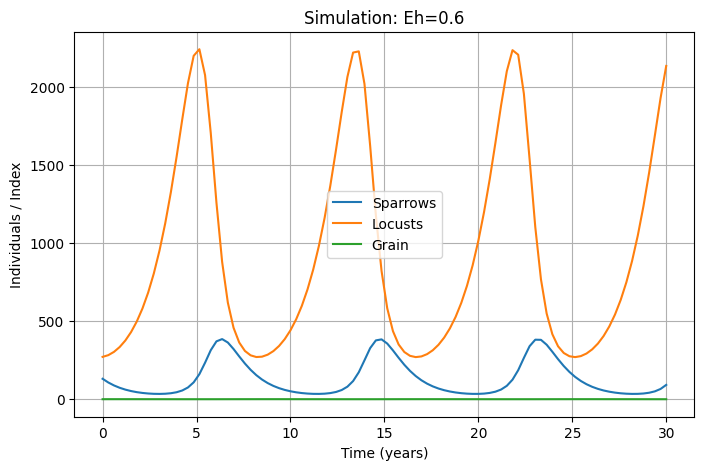

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         131.072 |         271.313 |           0.213
1955  |         107.398 |         282.296 |           0.312
1956  |          88.428 |         303.337 |           0.354
1957  |          73.386 |         334.422 |           0.365
1958  |          61.578 |         376.239 |           0.357
1959  |          52.421 |         430.033 |           0.337
1960  |          45.452 |         497.534 |           0.310
1961  |          40.318 |         580.911 |           0.280
1962  |          36.779 |         682.716 |           0.248
1963  |          34.711 |         805.772 |           0.217
1964  |          34.126 |         952.932 |           0.188
1965  |          35.220 |        1126.578 |           0.162

--- Simulation 13 with params [0.0070355  0.05189534 0.92438083 0.00355116 0.00123403 0.00592959
 0.02409232] ---


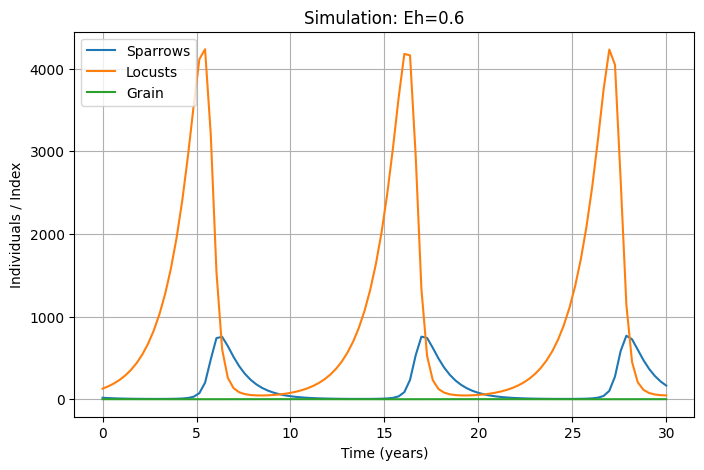

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          17.751 |         128.526 |           0.561
1955  |          13.966 |         156.325 |           0.568
1956  |          11.092 |         191.090 |           0.551
1957  |           8.915 |         234.478 |           0.518
1958  |           7.270 |         288.546 |           0.474
1959  |           6.039 |         355.851 |           0.422
1960  |           5.132 |         439.564 |           0.368
1961  |           4.486 |         543.606 |           0.315
1962  |           4.063 |         672.815 |           0.265
1963  |           3.843 |         833.142 |           0.220
1964  |           3.838 |        1031.853 |           0.181
1965  |           4.099 |        1277.723 |           0.149

--- Simulation 14 with params [0.0039646  0.0903497  1.44017901 0.00487683 0.00252068 0.00927503
 0.04593904] ---


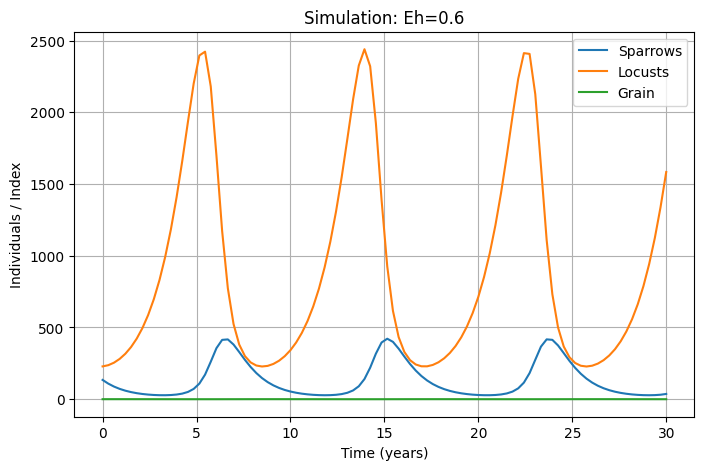

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         134.556 |         228.833 |           0.289
1955  |         108.802 |         237.235 |           0.364
1956  |          88.324 |         254.685 |           0.397
1957  |          72.177 |         281.075 |           0.405
1958  |          59.541 |         317.010 |           0.397
1959  |          49.733 |         363.641 |           0.377
1960  |          42.209 |         422.618 |           0.349
1961  |          36.547 |         496.069 |           0.316
1962  |          32.439 |         586.593 |           0.282
1963  |          29.681 |         697.240 |           0.247
1964  |          28.181 |         831.432 |           0.213
1965  |          27.980 |         992.745 |           0.183

--- Simulation 15 with params [0.00864796 0.06101383 0.8427282  0.00504116 0.00175841 0.00980275
 0.08010016] ---
Invalid result for case D, coexistence. 
Steady state no

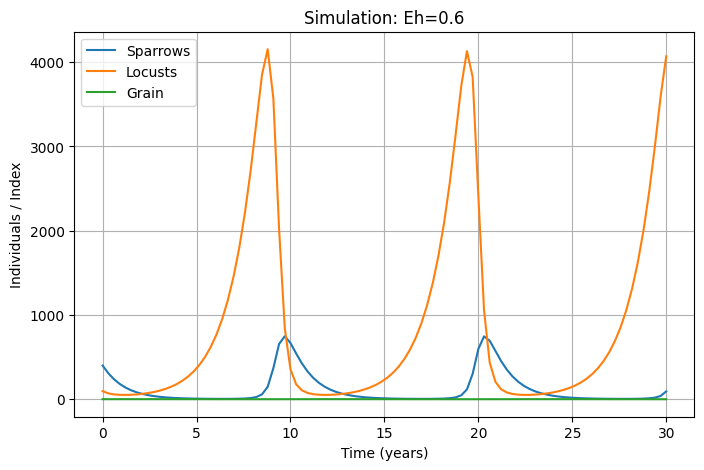

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         400.189 |          95.489 |           0.477
1955  |         309.098 |          69.660 |           0.516
1956  |         237.418 |          57.550 |           0.561
1957  |         181.905 |          52.265 |           0.603
1958  |         139.246 |          51.146 |           0.639
1959  |         106.594 |          52.937 |           0.668
1960  |          81.672 |          57.230 |           0.689
1961  |          62.703 |          63.998 |           0.703
1962  |          48.240 |          73.333 |           0.707
1963  |          37.231 |          85.652 |           0.702
1964  |          28.875 |         101.532 |           0.689
1965  |          22.512 |         121.686 |           0.667

--- Simulation 17 with params [0.0044907  0.01219553 2.16596961 0.0059081  0.00964291 0.00628829
 0.04293558] ---


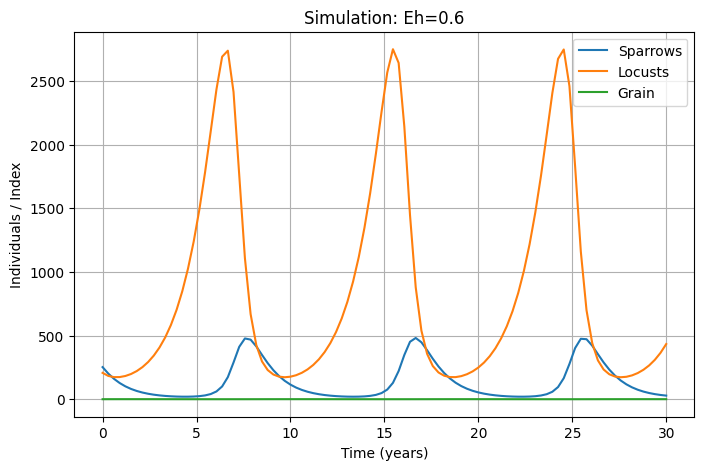

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         252.343 |         207.264 |           0.211
1955  |         201.680 |         183.267 |           0.331
1956  |         160.396 |         173.728 |           0.402
1957  |         127.397 |         174.185 |           0.446
1958  |         101.327 |         182.611 |           0.470
1959  |          80.885 |         198.262 |           0.479
1960  |          64.945 |         221.280 |           0.475
1961  |          52.575 |         252.284 |           0.460
1962  |          43.021 |         292.404 |           0.436
1963  |          35.690 |         343.251 |           0.405
1964  |          30.124 |         406.879 |           0.368
1965  |          25.980 |         485.837 |           0.328

--- Simulation 18 with params [8.04615734e-03 4.92975621e-02 1.15915961e+00 2.88415953e-03
 5.60206084e-04 2.90037273e-03 2.54103653e-02] ---


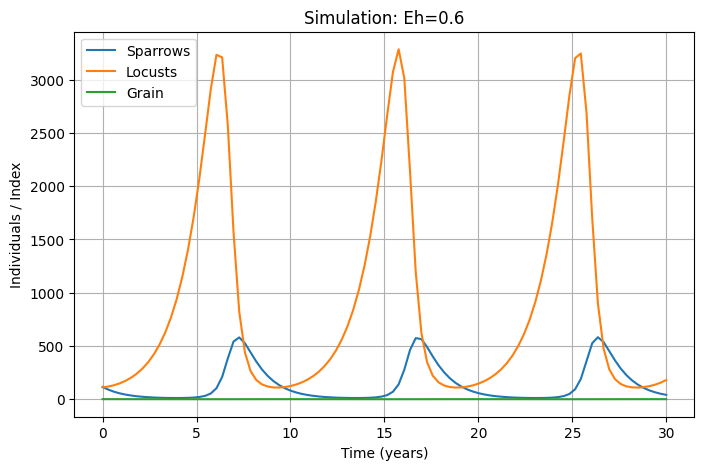

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         115.470 |         111.584 |           0.720
1955  |          90.105 |         119.045 |           0.670
1956  |          70.523 |         131.394 |           0.636
1957  |          55.450 |         148.872 |           0.609
1958  |          43.864 |         172.075 |           0.579
1959  |          34.980 |         201.987 |           0.546
1960  |          28.182 |         239.916 |           0.508
1961  |          23.000 |         287.546 |           0.466
1962  |          19.078 |         347.005 |           0.421
1963  |          16.146 |         420.929 |           0.372
1964  |          14.010 |         512.554 |           0.324
1965  |          12.539 |         625.823 |           0.277

--- Simulation 19 with params [7.77286462e-03 4.49671645e-02 2.37675729e+00 2.15757782e-03
 3.89855236e-03 5.13146030e-03 2.16424795e-02] ---


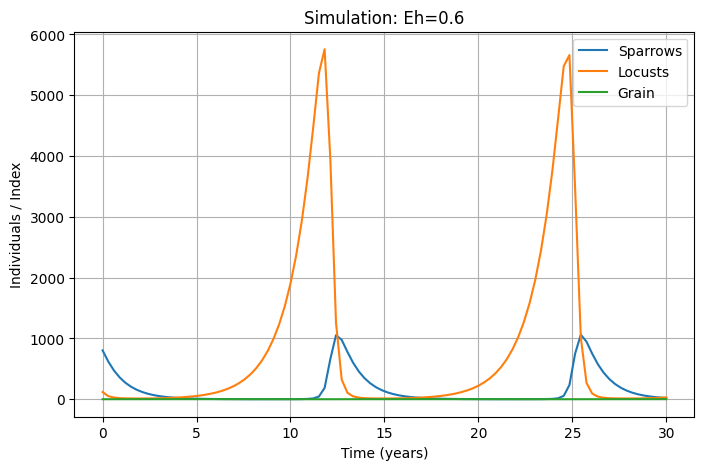

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         803.341 |         118.856 |           0.211
1955  |         619.941 |          50.564 |           0.339
1956  |         472.523 |          27.647 |           0.438
1957  |         358.539 |          18.407 |           0.520
1958  |         271.528 |          14.312 |           0.588
1959  |         205.447 |          12.451 |           0.647
1960  |         155.398 |          11.835 |           0.698
1961  |         117.553 |          12.029 |           0.740
1962  |          88.881 |          12.818 |           0.775
1963  |          67.265 |          14.209 |           0.804
1964  |          50.974 |          16.218 |           0.827
1965  |          38.606 |          18.885 |           0.843

--- Simulation 20 with params [6.60079915e-03 1.89485239e-02 5.53286023e-01 8.23836050e-03
 2.13747645e-04 5.33417268e-03 5.24308039e-02] ---
Invalid result for case D, c

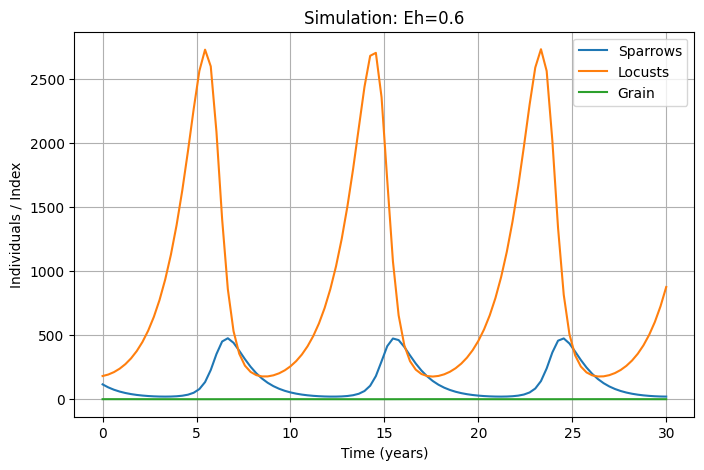

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         115.901 |         180.977 |           0.343
1955  |          92.419 |         192.665 |           0.411
1956  |          74.038 |         211.694 |           0.442
1957  |          59.724 |         238.404 |           0.449
1958  |          48.631 |         273.674 |           0.438
1959  |          40.083 |         318.848 |           0.415
1960  |          33.550 |         375.724 |           0.383
1961  |          28.629 |         446.584 |           0.346
1962  |          25.021 |         534.233 |           0.306
1963  |          22.524 |         642.033 |           0.266
1964  |          21.023 |         773.921 |           0.229
1965  |          20.508 |         934.332 |           0.195

--- Simulation 22 with params [0.00280691 0.06868365 1.05162444 0.00902474 0.00994064 0.00690344
 0.08416732] ---


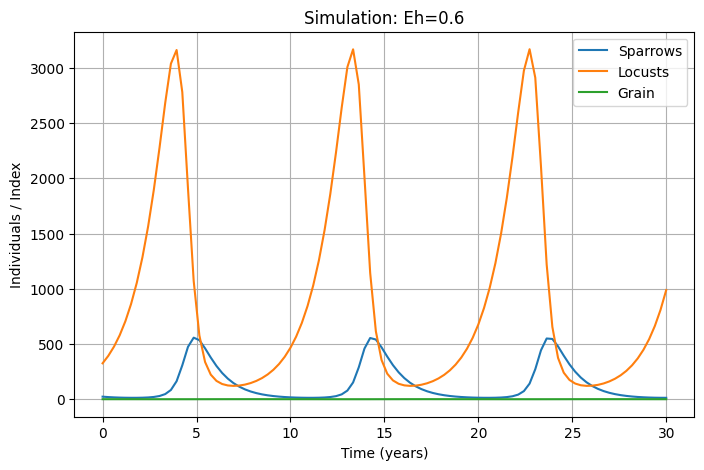

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          23.199 |         325.476 |           0.288
1955  |          19.487 |         392.597 |           0.325
1956  |          16.744 |         475.870 |           0.316
1957  |          14.798 |         578.847 |           0.286
1958  |          13.540 |         705.813 |           0.248
1959  |          12.929 |         861.846 |           0.210
1960  |          13.011 |        1052.808 |           0.176
1961  |          13.959 |        1285.123 |           0.147
1962  |          16.181 |        1565.054 |           0.122
1963  |          20.578 |        1896.735 |           0.101
1964  |          29.157 |        2277.062 |           0.084
1965  |          46.586 |        2682.644 |           0.072

--- Simulation 23 with params [0.00881361 0.09482979 1.69500399 0.00768239 0.00821272 0.00883539
 0.02882075] ---


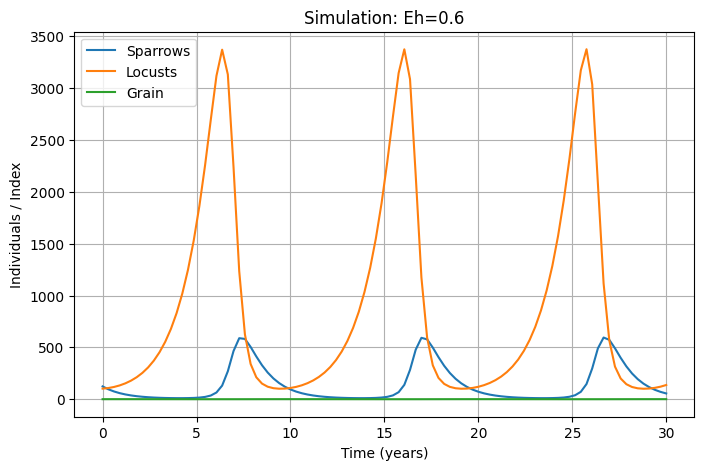

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         123.562 |         102.209 |           0.343
1955  |          96.121 |         107.892 |           0.448
1956  |          74.957 |         118.154 |           0.510
1957  |          58.677 |         133.093 |           0.542
1958  |          46.175 |         153.197 |           0.552
1959  |          36.593 |         179.300 |           0.543
1960  |          29.258 |         212.539 |           0.522
1961  |          23.662 |         254.401 |           0.489
1962  |          19.410 |         306.780 |           0.448
1963  |          16.207 |         372.025 |           0.402
1964  |          13.835 |         453.044 |           0.354
1965  |          12.138 |         553.404 |           0.306

--- Simulation 24 with params [9.90725253e-03 7.20882258e-02 1.83329104e+00 1.24719571e-03
 6.54399833e-03 3.89018783e-03 1.46846644e-02] ---


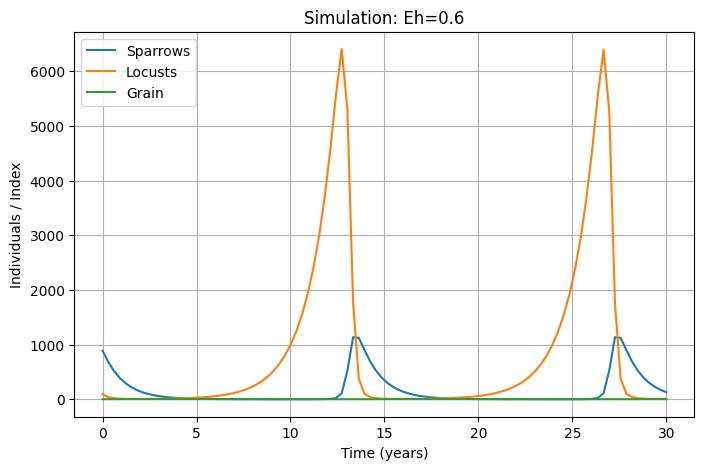

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         888.621 |          93.193 |           0.139
1955  |         681.639 |          35.508 |           0.302
1956  |         517.653 |          17.927 |           0.417
1957  |         391.798 |          11.258 |           0.506
1958  |         296.139 |           8.372 |           0.580
1959  |         223.680 |           7.048 |           0.643
1960  |         168.942 |           6.568 |           0.696
1961  |         127.532 |           6.540 |           0.742
1962  |          96.287 |           6.888 |           0.781
1963  |          72.786 |           7.582 |           0.813
1964  |          54.991 |           8.583 |           0.840
1965  |          41.543 |           9.942 |           0.861

--- Simulation 25 with params [0.00826042 0.0979794  2.04717102 0.00742331 0.00362601 0.00579534
 0.06706996] ---


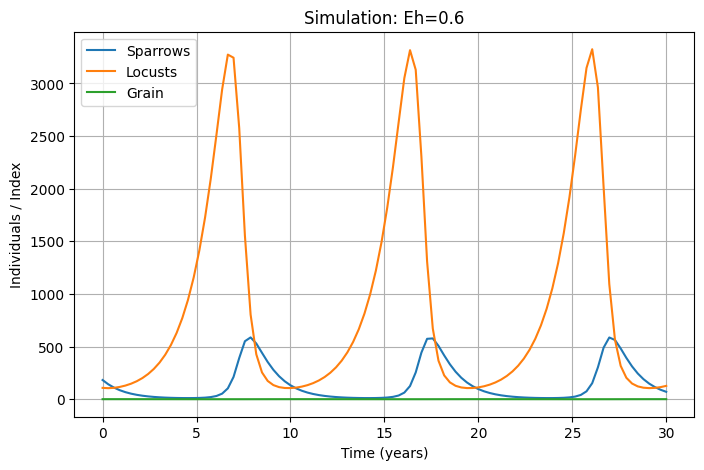

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         182.432 |         107.800 |           0.437
1955  |         141.968 |         105.067 |           0.500
1956  |         110.468 |         108.172 |           0.541
1957  |          86.099 |         116.545 |           0.565
1958  |          67.334 |         129.578 |           0.575
1959  |          52.904 |         147.405 |           0.573
1960  |          41.832 |         170.983 |           0.560
1961  |          33.353 |         201.327 |           0.536
1962  |          26.868 |         239.684 |           0.503
1963  |          21.928 |         287.787 |           0.464
1964  |          18.191 |         347.809 |           0.419
1965  |          15.400 |         422.424 |           0.371

--- Simulation 26 with params [0.00599254 0.0416799  1.30227895 0.00330085 0.00621495 0.00795047
 0.08659106] ---


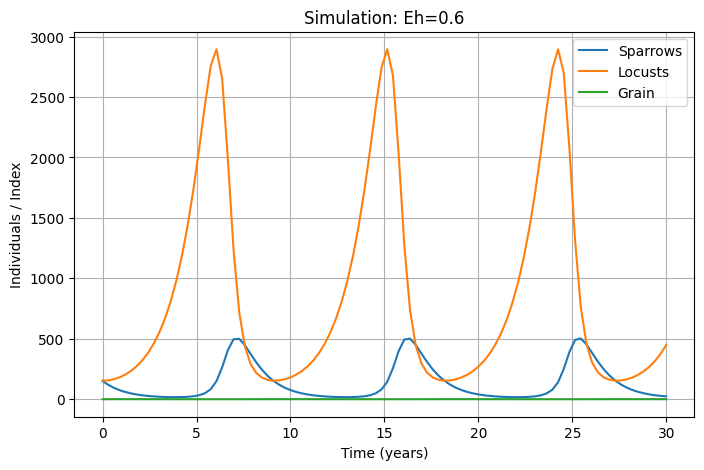

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         150.755 |         153.546 |           0.317
1955  |         119.050 |         156.058 |           0.408
1956  |          94.186 |         165.540 |           0.459
1957  |          74.803 |         181.546 |           0.483
1958  |          59.759 |         204.335 |           0.487
1959  |          48.125 |         234.655 |           0.476
1960  |          39.164 |         273.686 |           0.453
1961  |          32.300 |         323.040 |           0.421
1962  |          27.089 |         384.780 |           0.383
1963  |          23.199 |         461.470 |           0.342
1964  |          20.389 |         556.250 |           0.300
1965  |          18.500 |         672.877 |           0.258

--- Simulation 27 with params [4.10057926e-03 2.47001122e-02 2.47998849e+00 8.64067235e-03
 7.53921218e-03 2.05673553e-03 6.09745286e-02] ---


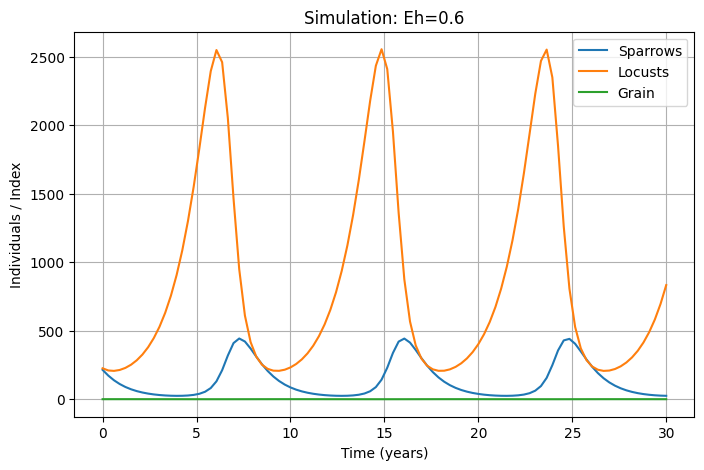

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         214.334 |         225.654 |           0.325
1955  |         172.490 |         209.894 |           0.383
1956  |         138.425 |         206.812 |           0.418
1957  |         111.158 |         213.420 |           0.438
1958  |          89.556 |         228.496 |           0.446
1959  |          72.572 |         251.897 |           0.442
1960  |          59.308 |         284.069 |           0.428
1961  |          49.017 |         326.084 |           0.405
1962  |          41.093 |         379.531 |           0.376
1963  |          35.072 |         446.421 |           0.342
1964  |          30.627 |         529.210 |           0.305
1965  |          27.503 |         630.933 |           0.268

--- Simulation 28 with params [0.00311685 0.08505035 0.76767772 0.00817762 0.00602432 0.00768451
 0.03178585] ---
Invalid result for case D, coexistence. 
Steady state no

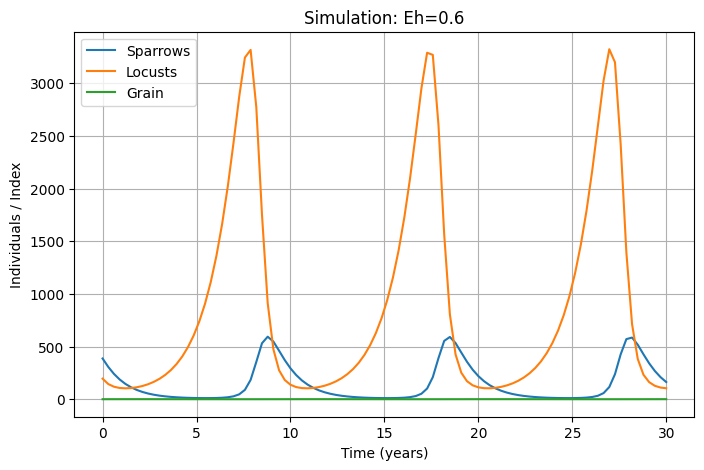

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |         386.874 |         195.345 |           0.233
1955  |         306.710 |         144.098 |           0.344
1956  |         240.423 |         118.802 |           0.422
1957  |         187.506 |         106.790 |           0.480
1958  |         145.859 |         103.450 |           0.525
1959  |         113.453 |         106.047 |           0.557
1960  |          88.382 |         113.469 |           0.577
1961  |          69.048 |         125.526 |           0.585
1962  |          54.190 |         142.560 |           0.582
1963  |          42.784 |         165.101 |           0.568
1964  |          34.037 |         194.091 |           0.544
1965  |          27.354 |         230.844 |           0.513

--- Simulation 30 with params [0.00542718 0.00710886 0.6345458  0.00574928 0.00909706 0.00852478
 0.07703868] ---
Invalid result for case D, coexistence. 
Steady state no

[array([1.75066382e-03, 3.01875976e-02, 2.21456188e+00, 5.28377334e-03,
        1.74947371e-03, 1.53680828e-03, 9.84138340e-02]),
 array([0.00235899, 0.07914062, 1.02392419, 0.00669052, 0.00442231,
        0.00123319, 0.01113881]),
 array([2.00428009e-03, 1.39970576e-02, 1.18109720e+00, 9.66475055e-03,
        9.61089820e-04, 6.63117795e-03, 7.57802238e-02]),
 array([0.00620939, 0.00384646, 1.23891709, 0.001744  , 0.00542818,
        0.00457662, 0.04824958]),
 array([0.00278054, 0.0272147 , 1.89403435, 0.00376444, 0.00799292,
        0.00841745, 0.03463936]),
 array([0.00567477, 0.07357627, 1.90852621, 0.00919674, 0.00709708,
        0.00749013, 0.08881745]),
 array([0.00756557, 0.087708  , 1.71508041, 0.00440732, 0.00430722,
        0.00252727, 0.05726178]),
 array([1.31758086e-03, 6.62478533e-02, 2.31833769e+00, 6.24455021e-03,
        4.79533631e-03, 2.46827774e-03, 9.54259750e-02]),
 array([1.07814203e-03, 2.51807761e-03, 1.51649555e+00, 2.40735909e-03,
        8.59153444e-03, 4.79

In [20]:
run_lhs_simulations(n_samples = 30, Eh = 0.0)
run_lhs_simulations(n_samples = 30, Eh = 0.2)
run_lhs_simulations(n_samples = 30, Eh = 0.4)
run_lhs_simulations(n_samples = 30, Eh = 0.6)